In [1]:
import pandas as pd
import os
import math
import numpy as np
import re
import matplotlib
import matplotlib.pyplot as plt
from numpy import linalg as LA
from scipy import stats
import networkx as nx
from networkx.algorithms import bipartite
import scipy
import itertools
import scipy.io as sio
%matplotlib inline
import csv
import copy
import statistics 
import statsmodels.api as sm
import sklearn
from collections import OrderedDict,defaultdict
from scipy.stats import t
from math import sqrt
import string
import csv
import nltk

from nltk.corpus import stopwords, wordnet as wn
from functools import reduce
import pickle 
from symspellpy.symspellpy import SymSpell, Verbosity;
from scipy.sparse import csr_matrix;
from scipy.sparse.csgraph import minimum_spanning_tree;

from nltk.stem import WordNetLemmatizer;
wnl = WordNetLemmatizer();
plt.rc('figure', figsize = (8,6))
w2v_filename = '/path/data/GoogleNews-vectors-negative300.bin'
if not os.path.exists(w2v_filename):
    w2v_filename = False 
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format(w2v_filename, binary=True)

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import download
download('stopwords')
download('punkt')  
stop_words = stopwords.words('english')

from ids import *

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

def load_csv_data(folder_name, file_name):
    csv_path = os.path.join(folder_name, file_name+".csv")
    return pd.read_csv(csv_path, encoding='latin-1')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/raiyanabdulbaten/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/raiyanabdulbaten/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df_annotated = load_csv_data("","data/df_annotation")
df_network = load_csv_data("","data/df_network")
df_ratings = load_csv_data("","data/df_ratings")

In [4]:
class Performance_Comparator(object):
    def __init__(self,
                dict_groups,
                df_annotated = df_annotated, 
                df_network = df_network,
                df_ratings =  df_ratings,
                turk_raters = turk_raters,
                process = True):
        
        self.groups = dict_groups
        self.df_idea_annotations = df_annotated    
        self.df_network = df_network
        self.df_ratings = df_ratings
        self.turk_raters = turk_raters
    
        self.all_ids = [ids for a_grp_cnd in self.groups \
            for id_dict in self.groups[a_grp_cnd] for ids in self.groups[a_grp_cnd][id_dict]]
        
        self.stop = set(stopwords.words('english'))
        self.stop.add('use')
        self.stop.add('make')
        self.stop.add('something')
        self.stop.add('put')
        
        #This sets up the symspell dictionary for autocorrect to work
        max_edit_distance_dictionary = 4;
        prefix_length = 7;
        # create object
        self.sym_spell = SymSpell(max_edit_distance_dictionary, prefix_length);
        # load dictionary
        dictionary_path = "data/frequency_dictionary_en_82_765.txt";
        term_index = 0  # column of the term in the dictionary text file
        count_index = 1  # column of the term frequency in the dictionary text file
        if not self.sym_spell.load_dictionary(dictionary_path, term_index, count_index):
            print("Dictionary file not found")
        self.hyponymCountDict = {}
        self.icDict = {}
        
        self.annotations_dict = {}
        self.ideas_dict = {}
        self.unique_dict = {}
        
        self.ideawise_ratings_dict = {}
        self.ratings_dict = {}
        self.cq_dict = {}
        
        self.alter_pairs = []
        self.alter_followers_dict = {}
        
        self.ego_followee_dict = {}
        self.ego_stat_followee_list = {}
        self.temporal_bosses_static = {}
        
        self.alter_dy_boss = {}
        self.alter_dy_lost = {}
        self.alter_stat_boss = {}
        self.alter_stat_lost = {}
        
        self.overall_unique_dict = {}
        self.group_unique_dict = {}
        self.group_cq_dict = {}
        
        if process:
            self.alter_popularity_setup()
            self.extract_annotations()
            self.compute_unique_idea_counts_per_person()
            self.compute_overall_unique_idea_counts()
            self.compute_group_unique_idea_counts()
            self.extract_ratings()
            self.extract_cq()
            self.compute_group_cq()
            
    def alter_popularity_setup(self):
        self.alter_pairs = []
        for run_, id_list in self.groups['alter_dy'].items():
            for id_ in id_list:
                self.alter_pairs.append([id_,0])

        i=0
        for run_, id_list in self.groups['alter_stat'].items():
            for id_ in id_list:
                self.alter_pairs[i][1] = id_
                i+=1  
                
        self.alter_followers_dict = {}
        all_dy_alters = [id_ for _,id_list in self.groups['alter_dy'].items() for id_ in id_list]
        all_dy_egos = [id_ for _,id_list in self.groups['ego_dy'].items() for id_ in id_list]
        all_stat_alters = [id_ for _,id_list in self.groups['alter_stat'].items() for id_ in id_list]
        all_stat_egos = [id_ for _,id_list in self.groups['ego_stat'].items() for id_ in id_list]
        
        for alter in all_dy_alters:
            self.alter_followers_dict[alter]=6*[0]
            
        self.ego_followee_dict = {}
        for ego in all_dy_egos:
            self.ego_followee_dict[ego]={1:[],2:[],3:[],4:[],5:[],6:[]}
            
        for ego in all_stat_egos:
            self.ego_stat_followee_list[ego]=[]

        for index, row in self.df_network.iterrows():
            if (row["ego_id"] in all_dy_egos and row["alter_id"] in all_dy_alters):
                self.alter_followers_dict[row["alter_id"]][row["round_id"]-1]+=1
                self.ego_followee_dict[row["ego_id"]][row["round_id"]].append(row["alter_id"])
            if (row["ego_id"] in all_stat_egos and row["alter_id"] in all_stat_alters):
                self.ego_stat_followee_list[row["ego_id"]].append(row["alter_id"])

        # 1:[] are the best ones from round 1, as they
        # were the ones followed at the end of round 1 / in round 2 (index is less by 1)
        self.temporal_bosses = {1:[],2:[],3:[],4:[],5:[]} 
        for r in range(1,6):
            self.temporal_bosses[r] = [alter for alter in all_dy_alters if self.alter_followers_dict[alter][r]>6]
        
        self.temporal_bosses_static = {}
        for round_ in self.temporal_bosses:
            self.temporal_bosses_static[round_]=[]
            for b in self.temporal_bosses[round_]:
                for t1,t2 in self.alter_pairs:
                    if t1==b:
                        self.temporal_bosses_static[round_].append(t2)
        
        self.alter_dy_boss = {}
        self.alter_dy_lost = {}
        self.alter_stat_boss = {}
        self.alter_stat_lost = {}

        for trial_id in range(1,7):
            
            self.alter_dy_boss[trial_id] = [id_ for id_ in self.groups['alter_dy'][trial_id] if id_ in self.temporal_bosses[5]]
            self.alter_dy_lost[trial_id] = list(set(self.groups['alter_dy'][trial_id]) - set(self.alter_dy_boss[trial_id]))

        self.alter_stat_boss = {key:[self.alter_pairs[np.where((np.array(self.alter_pairs))==dy_id)[0][0]][1] for dy_id in value] for key,value in self.alter_dy_boss.items()}
        self.alter_stat_lost = {key:[self.alter_pairs[np.where((np.array(self.alter_pairs))==dy_id)[0][0]][1] for dy_id in value] for key,value in self.alter_dy_lost.items()}
        
    def extract_annotations(self):
        print("==Loading annotation data==")
        
        for index, row in self.df_idea_annotations.iterrows():
            if (row["for_user_id"] in self.all_ids and row["annotation"]): 
                user_id = row["for_user_id"]
                round_id = row["round_id"]
                turn_id = row["turn_id"]
                annotation = row["annotation"]
                
                if user_id not in self.annotations_dict: # populate with template
                    self.annotations_dict[user_id]={1:{1:[],2:[]}, # 5 rounds, 2 turns in each
                                                   2:{1:[],2:[]},
                                                   3:{1:[],2:[]},
                                                   4:{1:[],2:[]},
                                                   5:{1:[],2:[]}}
                    self.ideas_dict[user_id]={1:{1:[],2:[]}, # 5 rounds, 2 turns in each
                                                   2:{1:[],2:[]},
                                                   3:{1:[],2:[]},
                                                   4:{1:[],2:[]},
                                                   5:{1:[],2:[]}}
                    
                self.annotations_dict[user_id][round_id][turn_id].append(annotation)
                self.ideas_dict[user_id][round_id][turn_id].append(row["idea_content"])
                
    def create_idea_tally(self, ids): 
        # this does not consider turns. Tallies are created over all the egoss' ideas in each round in the trial 
        tally_dict = {1:{},2:{},3:{},4:{},5:{}} # separate dicts for rounds, but not for turns
        for id_ in ids:
            for round_ in range(1,6):
                for turn_ in range(1,3):
                    for idea_id in self.annotations_dict[id_][round_][turn_]:
                        if idea_id not in tally_dict[round_]:
                            tally_dict[round_][idea_id] = 0
                        tally_dict[round_][idea_id] += 1

        return tally_dict
       
    def compute_unique_idea_counts_per_person(self, th_e=2, th_a=1):
        print("Computing unique idea counts per person 1/2")
        self.unique_dict = {}
        for trial_id in range(1,7):
            # do it for static and dynamic groups
            ego_s = self.groups['ego_stat'][trial_id]
            ego_d = self.groups['ego_dy'][trial_id]
            tally_dict = self.create_idea_tally(ego_s+ego_d)

            for id_ in ego_s+ego_d:
                if id_ not in self.unique_dict:
                    self.unique_dict[id_] = {1:{1:0,2:0},
                                        2:{1:0,2:0},
                                        3:{1:0,2:0},
                                        4:{1:0,2:0},
                                        5:{1:0,2:0},
                                       'total':0}
                for round_ in range(1,6):
                    for turn_ in range(1,3):
                        for idea_id in self.annotations_dict[id_][round_][turn_]:
                            if self.annotations_dict[id_][round_][turn_] and (tally_dict[round_][idea_id]<=th_e):
                                self.unique_dict[id_][round_][turn_]+=1

                self.unique_dict[id_]['total'] = np.sum([self.unique_dict[id_][round_][turn_] for round_ in range(1,6) for turn_ in range(1,3)])

            # now for alters
            alter_d = self.groups['alter_dy'][trial_id]
            tally_dict = self.create_idea_tally(alter_d)

            for id_ in alter_d:
                if id_ not in self.unique_dict:
                    self.unique_dict[id_] = {1:{1:0,2:0},
                                        2:{1:0,2:0},
                                        3:{1:0,2:0},
                                        4:{1:0,2:0},
                                        5:{1:0,2:0},
                                       'total':0}
                for round_ in range(1,6):
                    for turn_ in range(1,3):
                        for idea_id in self.annotations_dict[id_][round_][turn_]:
                            if self.annotations_dict[id_][round_][turn_] and (tally_dict[round_][idea_id]<=th_a):
                                self.unique_dict[id_][round_][turn_]+=1

                self.unique_dict[id_]['total'] = np.sum([self.unique_dict[id_][round_][turn_] for round_ in range(1,6) for turn_ in range(1,3)])

        for id_pair in self.alter_pairs:
            self.unique_dict[id_pair[1]] = copy.deepcopy(self.unique_dict[id_pair[0]])

    def compute_overall_unique_idea_counts(self, th=2):
        print("Computing unique idea counts per person 2/2")
        self.overall_unique_dict = {}
        select_conditions = ['ego_dy','ego_stat','crowd']
        select_ids = [ids for x in select_conditions for trials in self.groups[x] for ids in self.groups[x][trials]]
        tally_dict = self.create_idea_tally(select_ids)
        
        for id_ in select_ids:
            if id_ not in self.overall_unique_dict:
                self.overall_unique_dict[id_] = {1:{1:0,2:0},
                                    2:{1:0,2:0},
                                    3:{1:0,2:0},
                                    4:{1:0,2:0},
                                    5:{1:0,2:0},
                                   'total':0}
            for round_ in range(1,6):
                for turn_ in range(1,3):
                    for idea_id in self.annotations_dict[id_][round_][turn_]:
                        if self.annotations_dict[id_][round_][turn_] and (tally_dict[round_][idea_id]<=th):
                            self.overall_unique_dict[id_][round_][turn_]+=1
        
            self.overall_unique_dict[id_]['total'] = np.sum([self.overall_unique_dict[id_][round_][turn_] for round_ in range(1,6) for turn_ in range(1,3)])
      
    def compute_group_unique_idea_counts(self, th=1):
        print("Computing group-level unique idea counts")
        self.group_unique_dict = {'dynamic':{},'static':{},'crowd':{}}
        select_conditions = ['ego_dy','ego_stat','crowd']
        select_ids = [ids for x in select_conditions for trials in self.groups[x] for ids in self.groups[x][trials]]
        tally_dict = self.create_idea_tally(select_ids)
        
        for trial,ids in self.groups['ego_dy'].items(): #each trial is a datapoint
            if trial not in self.group_unique_dict['dynamic']:
                self.group_unique_dict['dynamic'][trial] = {1:[],2:[],3:[],4:[],5:[],'total':0}
            for id_ in ids:
                for round_ in range(1,6):
                    for turn_ in range(1,3):
                        for idea_id in self.annotations_dict[id_][round_][turn_]:
                            if self.annotations_dict[id_][round_][turn_] and (tally_dict[round_][idea_id]<=th) and idea_id not in self.group_unique_dict['dynamic'][trial][round_]:
                                self.group_unique_dict['dynamic'][trial][round_].append(idea_id)
                                self.group_unique_dict['dynamic'][trial]['total']+=1
        
        for trial,ids in self.groups['ego_stat'].items(): #each trial is a datapoint
            if trial not in self.group_unique_dict['static']:
                self.group_unique_dict['static'][trial] = {1:[],2:[],3:[],4:[],5:[],'total':0}
            for id_ in ids:
                for round_ in range(1,6):
                    for turn_ in range(1,3):
                        for idea_id in self.annotations_dict[id_][round_][turn_]:
                            if self.annotations_dict[id_][round_][turn_] and (tally_dict[round_][idea_id]<=th) and idea_id not in self.group_unique_dict['static'][trial][round_]:
                                self.group_unique_dict['static'][trial][round_].append(idea_id)
                                self.group_unique_dict['static'][trial]['total']+=1
        
        for trial,ids in self.groups['crowd'].items(): #each trial is a datapoint
            if trial not in self.group_unique_dict['crowd']:
                self.group_unique_dict['crowd'][trial] = {1:[],2:[],3:[],4:[],5:[],'total':0}
            for id_ in ids:
                for round_ in range(1,6):
                    for turn_ in range(1,3):
                        for idea_id in self.annotations_dict[id_][round_][turn_]:
                            if self.annotations_dict[id_][round_][turn_] and (tally_dict[round_][idea_id]<=th) and idea_id not in self.group_unique_dict['crowd'][trial][round_]:
                                self.group_unique_dict['crowd'][trial][round_].append(idea_id)
                                self.group_unique_dict['crowd'][trial]['total']+=1
        

    def extract_ratings(self):
        print("==Loading ratings data==")
        print("Setting up rater-ratee correspondences")
        
        accepted_rater_dict = {}
        if 'ego_dy' in self.groups:
            for trial_key,trial_list in self.groups['ego_dy'].items():
                for id_ in trial_list:
                    accepted_rater_dict[id_] = self.turk_raters
                    
        if 'ego_stat' in self.groups:            
            for trial_key,trial_list in self.groups['ego_stat'].items():
                for id_ in trial_list:
                    accepted_rater_dict[id_] = self.turk_raters
                    
        if 'crowd' in self.groups:         
            for trial_key,trial_list in self.groups['crowd'].items():
                for id_ in trial_list:
                    accepted_rater_dict[id_] = self.turk_raters
        
        if 'alter_dy' in self.groups:
            for trial_key,trial_list in self.groups['alter_dy'].items():
                for id_ in trial_list:
                    accepted_rater_dict[id_] = self.groups['ego_dy'][trial_key]
        
        if 'alter_stat' in self.groups:
            for trial_key,trial_list in self.groups['alter_stat'].items():
                for id_ in trial_list:
                    accepted_rater_dict[id_] = self.groups['ego_stat'][trial_key]
        
        print("Computing idea-wise ratings")
        self.ideawise_ratings_dict = {}
        
        for index, row in self.df_ratings.iterrows():    
            ratee_id = row['for_user_id']
            if (ratee_id in self.all_ids) and (row["from_user_id"] in accepted_rater_dict[ratee_id]):
                idea_id = row["idea_id"]
                rating = row["rating"]
                turn_id = row["turn_id"]
                round_id = row["round_id"] 
                
                if ratee_id not in self.ideawise_ratings_dict:
                    self.ideawise_ratings_dict[ratee_id] = {1:{1:{},2:{}}, # 5 rounds, 2 turns
                                                      2:{1:{},2:{}},
                                                      3:{1:{},2:{}},
                                                      4:{1:{},2:{}},
                                                      5:{1:{},2:{}}}
            
                if idea_id not in self.ideawise_ratings_dict[ratee_id][round_id][turn_id]:
                    self.ideawise_ratings_dict[ratee_id][round_id][turn_id][idea_id]=[]
                
                self.ideawise_ratings_dict[ratee_id][round_id][turn_id][idea_id].append(rating)
         
        print("Computing participant-wise ratings")
        for id_ in self.all_ids:
            self.ratings_dict[id_]={1:{1:[],2:[]},
                                    2:{1:[],2:[]},
                                    3:{1:[],2:[]},
                                    4:{1:[],2:[]},
                                    5:{1:[],2:[]}}
    
        for id_, value in self.ideawise_ratings_dict.items(): #value is the full dict initialized above
            for round_, value2 in value.items(): # value2 is the roundwise dict
                for turn_, value3 in value2.items(): #value3 is the turnwise dict
                    for idea_, value4 in value3.items(): #value4 are the lists associated with idea-keys
                        self.ratings_dict[id_][round_][turn_].append(np.mean(value4)) 

        for id_pair in self.alter_pairs:
            for round_ in range(1,6):
                for turn_ in range(1,3):
                    a=self.ratings_dict[id_pair[0]][round_][turn_]
                    b=self.ratings_dict[id_pair[1]][round_][turn_]  
                    self.ratings_dict[id_pair[0]][round_][turn_] = list((np.array(a)+np.array(b))/2.)
                    self.ratings_dict[id_pair[1]][round_][turn_] = list((np.array(a)+np.array(b))/2.)
                        
    def wordnet_pos(self,treebank):
        return wn.ADJ if treebank.startswith('J') else \
                (wn.VERB if treebank.startswith('V') else \
                 (wn.NOUN if treebank.startswith('N') else \
                  (wn.ADV if treebank.startswith('R') else '')))

    def preprocess(self,s):
        result = s.lower();
        result = nltk.pos_tag(nltk.word_tokenize(result));
        result = [(wnl.lemmatize(word.translate(str.maketrans(string.punctuation,len(string.punctuation)*' '))).strip(),self.wordnet_pos(pos)) for word,pos in result if (word not in self.stop and self.wordnet_pos(pos) is not '')];
        result = [(word,pos) for word,pos in result if not(len(word.split(' ')) == 2 and len(word.split(' ')[0]) == 1 and len(word.split(' ')[1]) == 1) and len(word) > 2];
        return result;
    
    def autocorrect(self,s,edit_dist=2):
        return self.sym_spell.lookup_compound(s, edit_dist)[0].term if len(self.sym_spell.lookup_compound(s, edit_dist)) > 0 else s;
    
    def toNoun(self,synset):
        if synset.pos() == 'n':
            return synset;
        return max([(derivation.synset(),derivation.count()) for lemma in synset.lemmas() for derivation in lemma.derivationally_related_forms() + lemma.pertainyms() if derivation.synset().pos() == 'n']+[(None,-1)], key=lambda t: t[1])[0];

    #Hyponyms are children
    def countHyponyms(self,synset,result=None):
        initialCall = result == None;
        
        if initialCall and str(synset) in self.hyponymCountDict:
            return self.hyponymCountDict[str(synset)];

        result = result if not initialCall else set();

        result.update(synset.hyponyms()+synset.instance_hyponyms());
        for s in synset.hyponyms() + synset.instance_hyponyms():
            self.countHyponyms(s,result);

        if(initialCall):
            self.hyponymCountDict[str(synset)] = len(result)
        return len(result)
    
    def ic(self,synset):
        self.icDict[str(synset)] = self.icDict[str(synset)] if self.icDict.get(str(synset)) else 1 - math.log2(self.countHyponyms(synset)+1)/math.log2(82115);
        return self.icDict[str(synset)];
    
    def sim(self,s1,s2):
        return 1 - .5*(self.ic(s1)+self.ic(s2)-2*max([self.ic(s) for s in s1.common_hypernyms(s2)]))
    
    def find_group(self, id_):
        if int(id_) in [id_ for id_ in self.groups['crowd'][1]]:
            return 0
        if int(id_) in [id_ for id_ in self.groups['crowd'][2]]:
            return 1
        alter_all = [id_ for trial_id in self.groups['alter_dy'] for id_ in self.groups['alter_dy'][trial_id]]+\
                    [id_ for trial_id in self.groups['alter_stat'] for id_ in self.groups['alter_stat'][trial_id]]
        if int(id_) in alter_all:
            return 2

        for key,value in self.groups['ego_dy'].items():
            if int(id_) in value:
                return int(str(key)+str(0))
        for key,value in self.groups['ego_stat'].items():
            if int(id_) in value:
                return int(str(key)+str(1))
    
    def roundwise_extractor_cq(self,round_id,turn='both',group_=None):
        subjectDict = defaultdict(lambda: []);
        for index, row in self.df_idea_annotations.iterrows():
            temp_turn_id = row["turn_id"]
            if (turn==1 and temp_turn_id!=1):
                continue
            if (turn==2 and temp_turn_id!=2):
                continue

            if (row["for_user_id"] in self.all_ids and row["annotation"] and row["round_id"]==round_id): #row["annotation"] is not allowed to be 0
                if not group_:
                    subjectDict[row["for_user_id"]].append((row["idea_content"],row["annotation"]))
                else:
                    group_id = self.find_group(row["for_user_id"])
                    subjectDict[group_id].append((row["idea_content"],row["annotation"]));
        
        #This just makes a new dict where all the ideas have been preprocessed
        processedSubjectDict = dict([(uid, [(self.preprocess(datum[0]), datum[1]) for datum in lst]) for uid,lst in subjectDict.items()]);
        
        #This edits the processedSubjectDict to replace pairs of words with one new concept
        for key in processedSubjectDict:
            for idea in processedSubjectDict[key]:
                for index in range(1,len(idea[0])):
                    if(len(wn.synsets(idea[0][index-1][0] + '_' + idea[0][index][0])) > 0):
                        syn = wn.synsets(idea[0][index-1][0] + '_' + idea[0][index][0])[0];
                        #print(syn);                
                        idea[0][index-1] = (idea[0][index-1][0] + '_' + idea[0][index][0],syn.pos());
                        idea[0][index] = idea[0][index-1];
        
        subjectSynsets = defaultdict(set)
        
        #This code makes a set of synsets for each person
        for person in processedSubjectDict:
            for idea in processedSubjectDict[person]:
                for word in idea[0]:
                    needsToBeChecked = True;
                    while(needsToBeChecked):
                        needsToBeChecked = False;
                        if(len(wn.synsets(word[0],word[1])) > 0):
                            subjectSynsets[person].add(wn.synsets(word[0],word[1])[0]);
                        elif(len(wn.synsets(word[0])) > 0):
                            subjectSynsets[person].add(wn.synsets(word[0])[0]);
                        else:
                            if(len(wn.synsets(word[0].replace(' ', '-'))) > 0):
                                subjectSynsets[person].add(wn.synsets(word[0].replace(' ', '-'))[0]);
                            elif(len(word[0].split(' ')) > 1 and len(wn.synsets(word[0].split(' ')[1])) > 0):
                                subjectSynsets[person].add(wn.synsets(word[0].split(' ')[1])[0]);
                            elif(word[0] != self.autocorrect(word[0])):
                                word = (self.autocorrect(word[0]), word[1]);
                                needsToBeChecked = True; 
       
        subjectSynsetsN = defaultdict(set)
        
        for subject in subjectSynsets:
            for synset in subjectSynsets[subject]:
                if synset.pos() == 'n':
                    subjectSynsetsN[subject].add(synset);
                elif self.toNoun(synset):
                    subjectSynsetsN[subject].add(self.toNoun(synset));
                    
        subjectTree = {};

        for subject in subjectSynsetsN:
            synsetCount = len(subjectSynsetsN[subject]);
            synsetList = list(subjectSynsetsN[subject]);
            subjectTree[subject] = np.zeros((synsetCount,synsetCount));
            for i in range(synsetCount):
                for j in range(i+1,synsetCount):
                    subjectTree[subject][(i,j)] = self.sim(synsetList[i],synsetList[j]);
        
        I = {};
        for subject in subjectTree: 
            result = minimum_spanning_tree(subjectTree[subject]*-1);
            I[subject] = result.sum()*-1;
        Q = {};

        for subject in subjectTree:
            Q[subject] = len(subjectTree[subject]) - I[subject];
        return Q

    def extract_cq(self):
        print("==Loading CQ data==")
        self.cq_dict = {}
        for id_ in self.all_ids:
            self.cq_dict[id_]={1:{1:0.0,2:0.0,'both':0.0},
                                2:{1:0.0,2:0.0,'both':0.0},
                                3:{1:0.0,2:0.0,'both':0.0},
                                4:{1:0.0,2:0.0,'both':0.0},
                                5:{1:0.0,2:0.0,'both':0.0},
                               'all':{1:0.0,2:0.0,'both':0.0} # 'all' is linear sum of the 5 rounds
                              }
        for round_ in range(1,6):
            print("Computing CQ of round "+str(round_)+"/5")
            for turn_ in [1,2,'both']:
                subjectDict = self.roundwise_extractor_cq(round_id=round_,turn=turn_)
                for key,val in subjectDict.items():
                    self.cq_dict[key][round_][turn_] = val
        
        for id_ in self.all_ids:
            for turn_ in [1,2,'both']:
                self.cq_dict[id_]['all'][turn_] = np.sum([self.cq_dict[id_][k][turn_] for k in range(1,6)])  
                
    def compute_group_cq(self):
        print("Computing group-wise CQ")
        self.group_cq_dict = {}
        for round_ in range(1,6):
            subjectDict = self.roundwise_extractor_cq(round_,turn='both',group_=True)
            for key,val in subjectDict.items():
                if key not in self.group_cq_dict:
                    self.group_cq_dict[key] ={1:0,2:0,3:0,4:0,5:0,'all':0}
                self.group_cq_dict[key][round_] = val
                
        for key in self.group_cq_dict:
            self.group_cq_dict[key]['all']= np.sum([self.group_cq_dict[key][k] for k in range(1,6)]) 
        

In [5]:
## Saving the computed values in a pickle file, to make re-runs less time consuming
## Uncomment this block to compute the object values from scratch

# select_conditions = ['ego_dy','alter_dy','ego_stat','alter_stat','crowd']
# select_ids = {x:ids_all[x] for x in select_conditions}
# comp = Performance_Comparator(select_ids) 

==Loading annotation data==
Computing unique idea counts per person 1/2
Computing unique idea counts per person 2/2
Computing group-level unique idea counts
==Loading ratings data==
Setting up rater-ratee correspondences
Computing idea-wise ratings
Computing participant-wise ratings
==Loading CQ data==
Computing CQ of round 1/5
Computing CQ of round 2/5
Computing CQ of round 3/5
Computing CQ of round 4/5
Computing CQ of round 5/5
Computing group-wise CQ


In [ ]:
# file_pi = open('data/study_info.obj', 'wb') 
# pickle.dump(comp, file_pi)

In [6]:
filehandler = open('data/study_info.obj', 'rb') 
comp = pickle.load(filehandler)

# Helper functions

In [7]:
def preprocess(doc):
    doc = doc.lower()  
    doc = word_tokenize(doc)
    doc = [w for w in doc if not w in stop_words] 
    doc = [w for w in doc if w.isalpha()] 
    return doc

In [8]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [9]:
def full_t_test(x1, x2, bonferroni = 1):
    N1 = len(x1)
    N2 = len(x2)
    df = N1+N2-2
    m1 = np.mean(x1)
    m2 = np.mean(x2)
    std1 = np.std(x1)
    std2 = np.std(x2)
    t, p = stats.ttest_ind(x1,x2)
    print('$m_1='+str(round(m1,2))+'$, $m_2='+str(round(m2,2))+'$, $t('+str(df)+')='+str(round(t,3))+'$, $p='+str(p)+ '$,')
    p_new = p * bonferroni
    print('Bonferroni-corrected (uncorrected $p$-val $\\times '+str(bonferroni)+'$) p='+str(p_new))
    from scipy.stats import t
    std_N1N2 = sqrt( ((N1 - 1)*(std1)**2 + (N2 - 1)*(std2)**2) / df) 

    diff_mean = m1 - m2
    MoE = t.ppf(0.975, df) * std_N1N2 * sqrt(1/N1 + 1/N2)
    ind_t_test = stats.ttest_ind(x1,x2)
    print ('$95\%$ C.I. for $m_1-m_2=[{:3.3f}, {:3.3f}]$'.format(diff_mean - MoE, diff_mean + MoE))


In [10]:
def my_regression_prep(comp):
    alter_regr_dict={}
    # populate y
    for key,value in comp.alter_followers_dict.items():
        alter_regr_dict[key]={'y':value[-1],'y_prime':value[-1]/18.,'u':0.,'u_prime':0.,'r':0.,'r_prime':0.,'q':0.,'q_prime':0.}
    
    # populate u and r
    for trial_id in range(1,7):
        tot_ideas_in_trial = np.sum([comp.unique_dict[id_]['total'] for id_ in comp.groups['alter_dy'][trial_id]])
        tot_ratings_in_trial = np.sum([np.mean([np.mean(comp.ratings_dict[id_][round_][1]) for round_ in range(1,6)]) for id_ in comp.groups['alter_dy'][trial_id]])
        tot_cq_in_trial = np.sum([comp.cq_dict[id_]['all']['both'] for id_ in comp.groups['alter_dy'][trial_id]])
        
        for id_ in comp.groups['alter_dy'][trial_id]:
            alter_regr_dict[id_]['u'] = comp.unique_dict[id_]['total']
            alter_regr_dict[id_]['u_prime'] = comp.unique_dict[id_]['total']/float(tot_ideas_in_trial)
            
            alter_regr_dict[id_]['r'] = np.mean([np.mean(comp.ratings_dict[id_][round_][1]) for round_ in range(1,6)])
            alter_regr_dict[id_]['r_prime'] = np.mean([np.mean(comp.ratings_dict[id_][round_][1]) for round_ in range(1,6)])/float(tot_ratings_in_trial)
            
            alter_regr_dict[id_]['q'] = comp.cq_dict[id_]['all']['both']
            alter_regr_dict[id_]['q_prime'] = comp.cq_dict[id_]['all']['both']/float(tot_cq_in_trial)
    
    return alter_regr_dict

In [11]:
def my_pearson(x1,x2):
    r,p = scipy.stats.pearsonr(x1, x2)
    num = len(x1)
    stderr = 1.0 / math.sqrt(num - 3)
    delta = 1.96 * stderr
    lower = math.tanh(math.atanh(r) - delta)
    upper = math.tanh(math.atanh(r) + delta)
    return (r,p,lower,upper)

In [12]:
def compute_jaccard_index3(n1,n2,round_id,comp):
    p = comp.annotations_dict[n1][round_id][1] #take turn 1 only
    q = comp.annotations_dict[n2][round_id][1]
    if len(set(p+q))==0:
        return 1
    else:
        return len(set(p).intersection(set(q))) / len(set(p+q))

In [13]:
def generate_adjacency(comp, save_=None):
    adjacency_dict={}
    for trial_id in range(1,7):
        my_adjacency = np.zeros((6,18,6))
        for ego_id in comp.groups['ego_dy'][trial_id]:
            for round_ in range(1,7):
                for alter_id in comp.ego_followee_dict[ego_id][round_]:
                    ego_index = comp.groups['ego_dy'][trial_id].index(ego_id)
                    alter_index = comp.groups['alter_dy'][trial_id].index(alter_id)
                    my_adjacency[alter_index,ego_index,round_-1]+=1
        if save_:
            filename='my_adjacency_trial'+str(trial_id)+'.mat'
            sio.savemat(filename, {'my_adjacency': my_adjacency})
        adjacency_dict[trial_id] = my_adjacency
    return adjacency_dict

In [14]:
def generate_adjacency_static(comp,save_=None):
    adjacency_dict={}
    for trial_id in range(1,7):
        my_adjacency = np.zeros((6,18,6))
        ego_ids = comp.groups['ego_stat'][trial_id]
        alter_ids = comp.groups['alter_stat'][trial_id]
        for ego_id in ego_ids:
            for round_ in range(1,7):
                for alter_id in comp.ego_stat_followee_list[ego_id]:
                    ego_index = ego_ids.index(ego_id)
                    alter_index = alter_ids.index(alter_id)
                    my_adjacency[alter_index,ego_index,round_-1]+=1
        if save_:
            filename='my_adjacency_static_trial'+str(trial_id)+'.mat'
            sio.savemat(filename, {'my_adjacency': my_adjacency})
        adjacency_dict[trial_id] = my_adjacency
    return adjacency_dict

In [15]:
def compute_wmd_distance2(n1,n2,round_id,comp):
    p = comp.ideas_dict[n1][round_id][2] #take turn 2 only
    q = comp.ideas_dict[n2][round_id][2]
    doc_p = " ".join(p)
    doc_q = " ".join(q)
    doc_p = preprocess(doc_p)
    doc_q = preprocess(doc_q)
    
    return model.wmdistance(doc_p,doc_q) if (len(doc_p)>1 and len(doc_q)>1) else 0

In [16]:
def compute_wmd_distance3(n1,n2,round_id,comp):
    p = comp.ideas_dict[n1][round_id][1] #take turn 1 only for crowd
    q = comp.ideas_dict[n2][round_id][1]
    doc_p = " ".join(p)
    doc_q = " ".join(q)
    doc_p=preprocess(doc_p)
    doc_q=preprocess(doc_q)
    return model.wmdistance(doc_p,doc_q) if (len(doc_p)>1 and len(doc_q)>1) else 0

# Experiments

### Connection update per ego

In [19]:
def compute_personal_delta(comp):
    plt.rc('figure', figsize = (18,10))
    y=[]
    x=[]
    for trial_id in range(1,7):
        personal_delta = {2:[],3:[],4:[],5:[],6:[]} # 2 means p0-p1
        for round_ in range(2,7):
            for ego in comp.groups['ego_dy'][trial_id]:
                personal_delta[round_].append(len(list(set(comp.ego_followee_dict[ego][round_]) - set(comp.ego_followee_dict[ego][round_-1]))))
        
        d=np.array([np.mean(k) for _,k in personal_delta.items()])
        e=np.array([np.std(k) for _,k in personal_delta.items()])    
        
        m= np.array([mean_confidence_interval(k)[0] for _,k in personal_delta.items()])
        l= np.array([mean_confidence_interval(k)[1] for _,k in personal_delta.items()])
        h= np.array([mean_confidence_interval(k)[2] for _,k in personal_delta.items()])

        for idx, i in enumerate(m):
            y.append(i)
            x.append(idx+1)
        
        plt.subplot(2,3,trial_id);
        plt.plot(range(1,6), m, lw = 2, color = '#7663b0' , alpha = 1, label = 'Mean')
        plt.fill_between(range(1,6), l, h, color ='#7663b0'  , alpha = 0.4, label = 'Std') 
        plt.title("Trial "+str(trial_id))
        plt.xlabel("(At the end of) Round")
        plt.xticks([1,2,3,4,5])
        plt.ylim([-0.4,2])
        plt.ylabel("Connection updates per ego")
        plt.legend(loc = 'best') 
        plt.savefig('plots/conn_update_per_ego.eps', format='eps')
    
    x1 = sm.add_constant(x)
    model2 = sm.OLS(y, x1).fit()
    predictions = model2.predict(x1) # make the predictions by the model

    print(model2.summary())  
    print(stats.linregress(x,y)) 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     23.54
Date:                Tue, 19 Nov 2019   Prob (F-statistic):           4.16e-05
Time:                        02:51:03   Log-Likelihood:                 2.6718
No. Observations:                  30   AIC:                            -1.344
Df Residuals:                      28   BIC:                             1.459
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8935      0.098      9.108      0.0

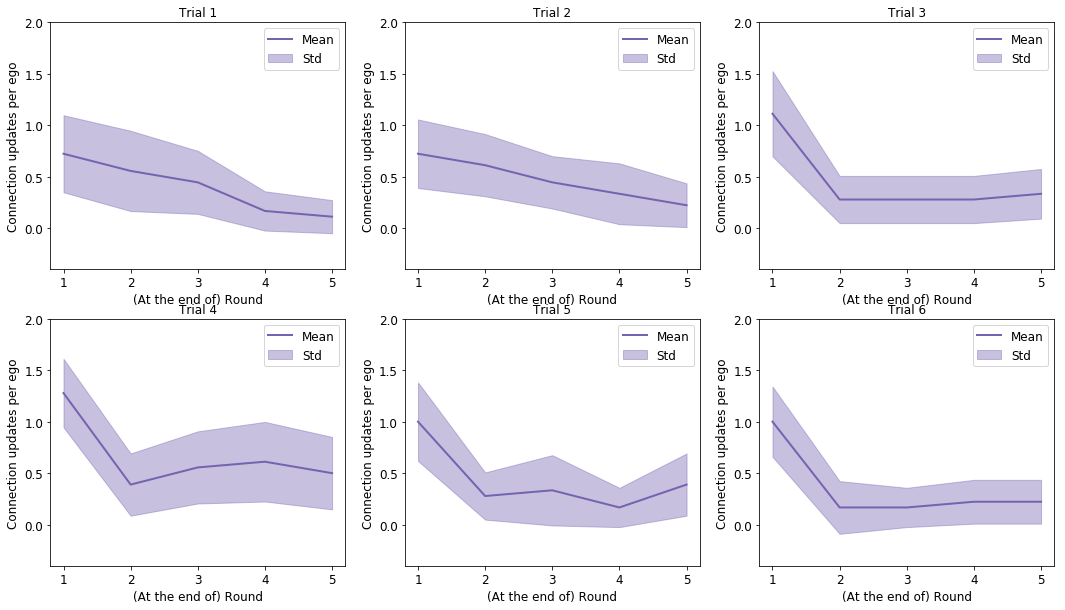

In [20]:
compute_personal_delta(comp)

### Aggregated: popular vs unpopular

In [21]:
def compute_lumped_temporal_boss_vs_lost_uniq(comp):
    plt.rc('figure', figsize = (8,6))
    cc_boss_m=[]
    cc_boss_l=[]
    cc_boss_u=[]
    cc_lost_m=[]
    cc_lost_l=[]
    cc_lost_u=[]

    for round_ in range(1,6):
        boss2 = [np.sum([comp.unique_dict[id_][round__][1] for round__ in range(1,round_+1)]) for trial_id in range(1,7) for id_ in comp.alter_dy_boss[trial_id]]
        lost2 = [np.sum([comp.unique_dict[id_][round__][1] for round__ in range(1,round_+1)]) for trial_id in range(1,7) for id_ in comp.alter_dy_lost[trial_id]]
        
        cc_boss_m.append(mean_confidence_interval(boss2)[0])
        cc_boss_l.append(mean_confidence_interval(boss2)[1])
        cc_boss_u.append(mean_confidence_interval(boss2)[2])
        cc_lost_m.append(mean_confidence_interval(lost2)[0])
        cc_lost_l.append(mean_confidence_interval(lost2)[1])
        cc_lost_u.append(mean_confidence_interval(lost2)[2])

        if round_==5:
            a=np.array(boss2)
            b=np.array(lost2)
            full_t_test(a, b)
    
    h=np.array(cc_boss_m)
    i=np.array(cc_boss_l)
    j=np.array(cc_boss_u)
    k=np.array(cc_lost_m)
    l=np.array(cc_lost_l)
    m=np.array(cc_lost_u)
    
    _, ax1 = plt.subplots()
    ax1.plot(range(1,6), h, lw = 1, color = '#539caf', alpha = 1, label = 'Popular Mean')
    ax1.fill_between(range(1,6), i, j, color = '#539caf', alpha = 0.4, label = 'Popular 95% CI')
    ax1.plot(range(1,6), k, lw = 1, color = '#7663b0', alpha = 1, label = 'Unpopular Mean')
    ax1.fill_between(range(1,6), l, m, color = '#7663b0', alpha = 0.4, label = 'Unpopular 95% CI')
    
    ax1.set_title("Cumulative non-redundant ideas")
    ax1.set_xlabel("Round")
    ax1.set_ylabel("Cumulative non-redundant ideas")
    ax1.legend(loc = 'best') 
    plt.xticks([1,2,3,4,5])
    plt.savefig('plots/boss_lost_cumu_uniq.eps', format='eps')      

$m_1=23.77$, $m_2=14.35$, $t(34)=7.291$, $p=1.9178728586931627e-08$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=1.9178728586931627e-08
$95\%$ C.I. for $m_1-m_2=[6.871, 11.972]$


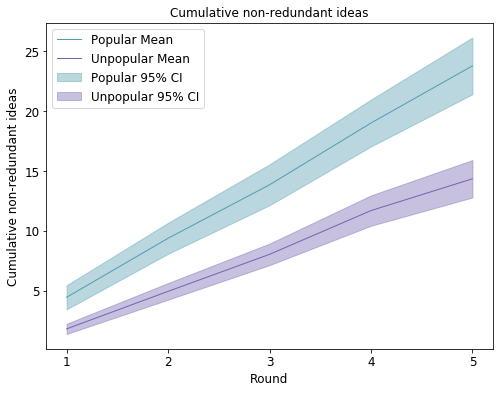

In [22]:
compute_lumped_temporal_boss_vs_lost_uniq(comp)

In [23]:
def compute_lumped_boss_vs_lost_ratings(comp):
    means=[]
    conf=[]
    boss = [np.mean([np.mean(comp.ratings_dict[id_][round_][1]) for round_ in range(1,6)]) for trial_id in range(1,7) for id_ in comp.alter_dy_boss[trial_id]]
    lost = [np.mean([np.mean(comp.ratings_dict[id_][round_][1]) for round_ in range(1,6)]) for trial_id in range(1,7) for id_ in comp.alter_dy_lost[trial_id]]
    a=np.array(boss)
    b=np.array(lost)
    t, p = stats.ttest_ind(a,b)
    full_t_test(a, b)
    print(" ")
    means.append(mean_confidence_interval(boss)[0])
    conf.append([mean_confidence_interval(boss)[1],mean_confidence_interval(boss)[2]])

    means.append(mean_confidence_interval(lost)[0])
    conf.append([mean_confidence_interval(lost)[1],mean_confidence_interval(lost)[2]])
    
    means=np.array(means)
    conf=np.array(conf)
    yerr = np.c_[means-conf[:,0],conf[:,1]-means ].T

    plt.bar(range(len(means)), means, yerr=yerr,color=['#539caf','#7663b0'],alpha=0.7,error_kw=dict(ecolor='#6A6A6A',alpha=1, lw=3))
    my_xticks = ['Popular','Unpopular']
    plt.xticks([0,1], my_xticks)
    plt.ylim([1,3.3])
    plt.ylabel('Average rating')
    plt.savefig('plots/boss_lost_cumu_rating.eps', format='eps')   

$m_1=3.05$, $m_2=2.64$, $t(34)=5.699$, $p=2.1168677303637253e-06$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=2.1168677303637253e-06
$95\%$ C.I. for $m_1-m_2=[0.272, 0.562]$
 


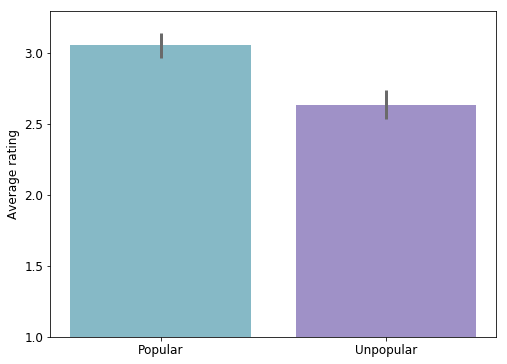

In [24]:
compute_lumped_boss_vs_lost_ratings(comp)

In [25]:
def compute_lumped_temporal_boss_vs_lost_cq(comp):
    plt.rc('figure', figsize = (8,6))
    
    cc_boss_m=[]
    cc_boss_l=[]
    cc_boss_u=[]
    cc_lost_m=[]
    cc_lost_l=[]
    cc_lost_u=[]

    for round_ in range(1,6):
        boss2 = [np.sum([comp.cq_dict[id_][round__][1] for round__ in range(1,round_+1)]) for trial_id in range(1,7) for id_ in comp.alter_dy_boss[trial_id]]
        lost2 = [np.sum([comp.cq_dict[id_][round__][1] for round__ in range(1,round_+1)]) for trial_id in range(1,7) for id_ in comp.alter_dy_lost[trial_id]]

        cc_boss_m.append(mean_confidence_interval(boss2)[0])
        cc_boss_l.append(mean_confidence_interval(boss2)[1])
        cc_boss_u.append(mean_confidence_interval(boss2)[2])
        cc_lost_m.append(mean_confidence_interval(lost2)[0])
        cc_lost_l.append(mean_confidence_interval(lost2)[1])
        cc_lost_u.append(mean_confidence_interval(lost2)[2])

        if round_==5:
            a=np.array(boss2)
            b=np.array(lost2)
            t, p = stats.ttest_ind(a,b)
            full_t_test(a, b)
            print(" ")
    
    h=np.array(cc_boss_m)
    i=np.array(cc_boss_l)
    j=np.array(cc_boss_u)
    k=np.array(cc_lost_m)
    l=np.array(cc_lost_l)
    m=np.array(cc_lost_u)
    
    _, ax1 = plt.subplots()
    
    ax1.plot(range(1,6), h, lw = 1, color = '#539caf', alpha = 1, label = 'Popular Mean')
    ax1.fill_between(range(1,6), i, j, color = '#539caf', alpha = 0.4, label = 'Popular 95% CI')
    ax1.plot(range(1,6), k, lw = 1, color = '#7663b0', alpha = 1, label = 'Unpopular Mean')
    ax1.fill_between(range(1,6), l, m, color = '#7663b0', alpha = 0.4, label = 'Unpopular 95% CI')
    
    ax1.set_title("Cumulative Q")
    ax1.set_xlabel("Round")
    ax1.set_ylabel("Cumulative Q")
    ax1.legend(loc = 'best') 
    plt.xticks([1,2,3,4,5])
    plt.savefig('plots/boss_lost_cumu_cq.eps', format='eps')      
    

$m_1=57.77$, $m_2=36.74$, $t(34)=5.806$, $p=1.537941425062231e-06$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=1.537941425062231e-06
$95\%$ C.I. for $m_1-m_2=[13.895, 28.160]$
 


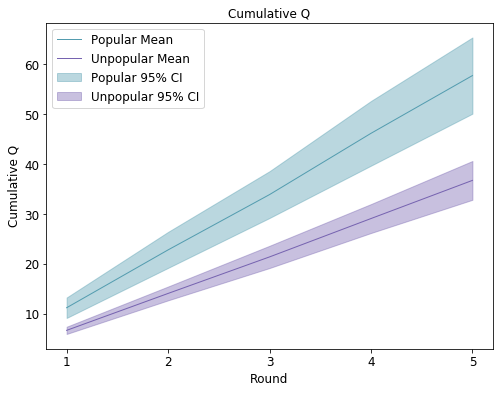

In [26]:
compute_lumped_temporal_boss_vs_lost_cq(comp)

### Trialwise: popular vs unpopular

In [27]:
def compute_temporal_boss_vs_lost_uniq(comp):
    plt.rc('figure', figsize = (18,13))
    for trial_id in range(1,7):
        c_boss_mean_collection=[]
        c_boss_std_collection=[]
        c_lost_mean_collection=[]
        c_lost_std_collection=[]
        
        for round_ in range(1,6):
            boss2 = [np.sum([comp.unique_dict[id_][round__][1] for round__ in range(1,round_+1)]) for id_ in comp.alter_dy_boss[trial_id]]
            lost2 = [np.sum([comp.unique_dict[id_][round__][1] for round__ in range(1,round_+1)]) for id_ in comp.alter_dy_lost[trial_id]]
            
            c_boss_mean_collection.append(np.mean(boss2))
            c_boss_std_collection.append(np.std(boss2))
            c_lost_mean_collection.append(np.mean(lost2))
            c_lost_std_collection.append(np.std(lost2))
            
            if round_==5:
                a=np.array(boss2)
                b=np.array(lost2)
                t, p = stats.ttest_ind(a,b)
                print("Trial "+str(trial_id)+":")
                full_t_test(a, b)
                print(" ")
        
        d=np.array(c_boss_mean_collection)
        e=np.array(c_boss_std_collection)
        f=np.array(c_lost_mean_collection)
        g=np.array(c_lost_std_collection)

        plt.subplot(2,3,trial_id);
        plt.plot(range(1,6), c_boss_mean_collection, lw = 2, color = '#48c8ff', alpha = 1, label = 'Popular Mean')
        plt.fill_between(range(1,6), list(d-e), list(d+e), color = '#48c8ff', alpha = 0.4, label = 'Popular Std')
        plt.plot(range(1,6), c_lost_mean_collection, lw = 2, color = '#6655ac', alpha = 1, label = 'Unpopular Mean')
        plt.fill_between(range(1,6), list(f-g), list(f+g), color = '#6655ac', alpha = 0.4, label = 'Unpopular Std')

        plt.title('Trial: '+str(trial_id)+', p-val: '+str(round(p,3)),fontsize=15)
        plt.ylabel('Cumulative non-redundant idea count',fontsize=15)
        plt.xlabel("Round", fontsize=15)
        plt.xticks([1,2,3,4,5])
        plt.legend(loc = 'best',fontsize=15) 
        plt.savefig('plots/SI_boss_loss_uniq.eps', format='eps') 

Trial 1:
$m_1=17.0$, $m_2=9.5$, $t(4)=5.222$, $p=0.006417236354026187$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=0.006417236354026187
$95\%$ C.I. for $m_1-m_2=[4.047, 10.953]$
 
Trial 2:
$m_1=21.5$, $m_2=12.75$, $t(4)=2.879$, $p=0.045039597659120585$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=0.045039597659120585
$95\%$ C.I. for $m_1-m_2=[2.077, 15.423]$
 
Trial 3:
$m_1=25.0$, $m_2=14.0$, $t(4)=6.351$, $p=0.0031495162388124314$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=0.0031495162388124314
$95\%$ C.I. for $m_1-m_2=[6.923, 15.077]$
 
Trial 4:
$m_1=26.0$, $m_2=15.75$, $t(4)=6.629$, $p=0.0026860317772597797$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=0.0026860317772597797
$95\%$ C.I. for $m_1-m_2=[6.532, 13.968]$
 
Trial 5:
$m_1=25.33$, $m_2=15.0$, $t(4)=6.609$, $p=0.0027165234869944606$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=0.0027165234869944606
$95\%$ C.I. for $m_1-m_2=[6.789, 13.878]$
 
Trial 6:
$m_1=27.0$, $

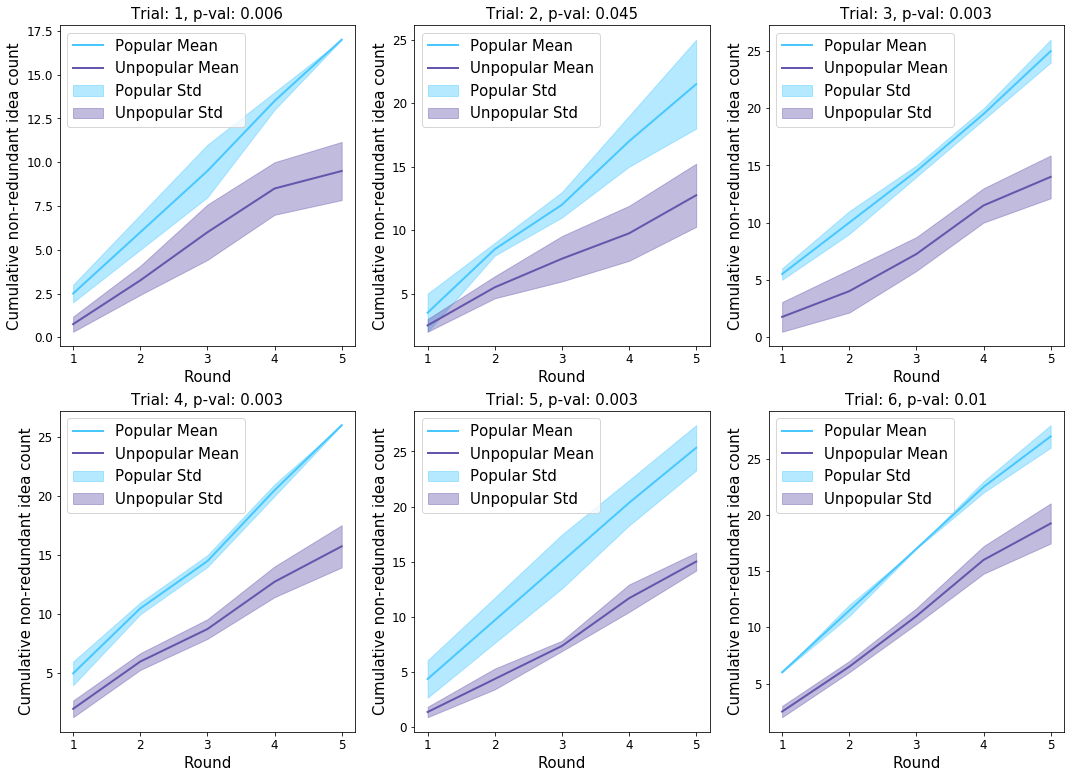

In [28]:
compute_temporal_boss_vs_lost_uniq(comp)

In [29]:
def compute_boss_vs_lost_ratings(comp):
    plt.rc('figure', figsize = (18,13))
    for trial_id in range(1,7):
        means=[]
        conf=[]
        boss = [np.mean([np.mean(comp.ratings_dict[id_][round_][1]) for round_ in range(1,6)]) for id_ in comp.alter_dy_boss[trial_id]]
        lost = [np.mean([np.mean(comp.ratings_dict[id_][round_][1]) for round_ in range(1,6)]) for id_ in comp.alter_dy_lost[trial_id]]
        a=np.array(boss)
        b=np.array(lost)
        t, p = stats.ttest_ind(a,b)
        print("Trial "+str(trial_id)+":")
        full_t_test(a, b)
        print(" ")

        means.append(mean_confidence_interval(boss)[0])
        conf.append([mean_confidence_interval(boss)[1],mean_confidence_interval(boss)[2]])

        means.append(mean_confidence_interval(lost)[0])
        conf.append([mean_confidence_interval(lost)[1],mean_confidence_interval(lost)[2]])

        means=np.array(means)
        conf=np.array(conf)
        yerr = np.c_[means-conf[:,0],conf[:,1]-means ].T
        
        plt.subplot(2,3,trial_id);
        plt.bar(range(len(means)), means, yerr=yerr,color=['#48c8ff','#6655ac'],alpha=0.7,error_kw=dict(ecolor='#6A6A6A',alpha=1, lw=3))
        my_xticks = ['Popular','Unpopular']
        plt.xticks([0,1], my_xticks,fontsize=15)
        plt.title('Trial: '+str(trial_id)+', p-val: '+str(round(p,4)),fontsize=15)
        plt.ylabel('Average novelty rating',fontsize=15)
    plt.savefig('plots/SI_boss_loss_rating.eps', format='eps')        

Trial 1:
$m_1=3.24$, $m_2=2.98$, $t(4)=3.675$, $p=0.021299613987080735$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=0.021299613987080735
$95\%$ C.I. for $m_1-m_2=[0.112, 0.406]$
 
Trial 2:
$m_1=3.14$, $m_2=2.77$, $t(4)=2.67$, $p=0.055810237058073496$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=0.055810237058073496
$95\%$ C.I. for $m_1-m_2=[0.037, 0.701]$
 
Trial 3:
$m_1=3.15$, $m_2=2.49$, $t(4)=4.264$, $p=0.013010796556482953$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=0.013010796556482953
$95\%$ C.I. for $m_1-m_2=[0.292, 1.029]$
 
Trial 4:
$m_1=2.99$, $m_2=2.63$, $t(4)=4.207$, $p=0.01361373189578276$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=0.01361373189578276
$95\%$ C.I. for $m_1-m_2=[0.169, 0.556]$
 
Trial 5:
$m_1=2.91$, $m_2=2.43$, $t(4)=5.98$, $p=0.003931231107410261$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=0.003931231107410261
$95\%$ C.I. for $m_1-m_2=[0.297, 0.659]$
 
Trial 6:
$m_1=2.96$, $m_2=2.47$, $t(4)=

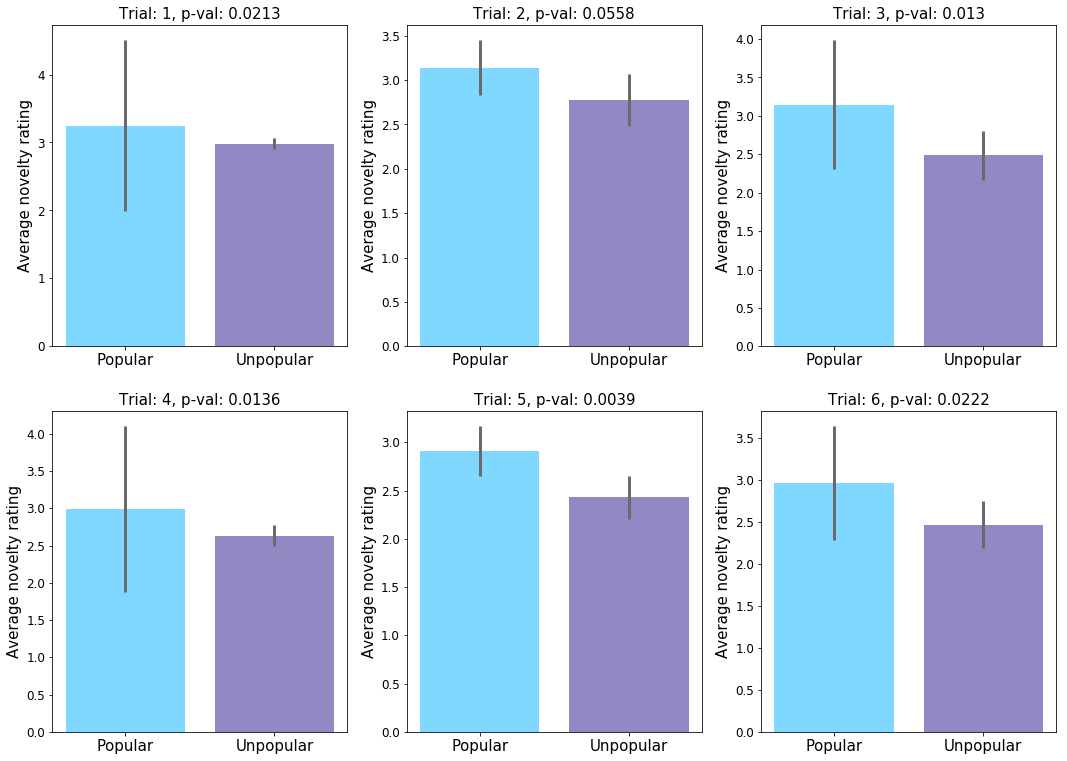

In [30]:
compute_boss_vs_lost_ratings(comp)

In [32]:
def compute_temporal_boss_vs_lost_cq(comp):
    plt.rc('figure', figsize = (18,13))
    for trial_id in range(1,7):
        c_boss_mean_collection=[]
        c_boss_std_collection=[]
        c_lost_mean_collection=[]
        c_lost_std_collection=[]
        
        for round_ in range(1,6):
            boss2 = [np.sum([comp.cq_dict[id_][round__][1] for round__ in range(1,round_+1)]) for id_ in comp.alter_dy_boss[trial_id]]
            lost2 = [np.sum([comp.cq_dict[id_][round__][1] for round__ in range(1,round_+1)]) for id_ in comp.alter_dy_lost[trial_id]]
            
            c_boss_mean_collection.append(np.mean(boss2))
            c_boss_std_collection.append(np.std(boss2))
            c_lost_mean_collection.append(np.mean(lost2))
            c_lost_std_collection.append(np.std(lost2))
            
            if round_==5:
                aa=np.array(boss2)
                bb=np.array(lost2)
                t, p = stats.ttest_ind(aa,bb)
                print("Trial "+str(trial_id)+":")
                full_t_test(aa, bb)
                print(" ")
        
        g=np.array(c_boss_mean_collection)
        h=np.array(c_boss_std_collection)
        i=np.array(c_lost_mean_collection)
        j=np.array(c_lost_std_collection)
        
        plt.subplot(2,3,trial_id);
        plt.plot(range(1,6), c_boss_mean_collection, lw = 2, color = '#48c8ff', alpha = 1, label = 'Popular Mean')
        plt.fill_between(range(1,6), list(g-h), list(g+h), color = '#48c8ff', alpha = 0.4, label = 'Popular Std')
        plt.plot(range(1,6), c_lost_mean_collection, lw = 2, color = '#6655ac', alpha = 1, label = 'Unpopular Mean')
        plt.fill_between(range(1,6), list(i-j), list(i+j), color = '#6655ac', alpha = 0.4, label = 'Unpopular Std')

        plt.title('Trial: '+str(trial_id)+', p-val: '+str(round(p,4)),fontsize=15)
        plt.xlabel("Round",fontsize=15)
        plt.ylabel("Cumulative Q",fontsize=15)
        plt.legend(loc = 'upper left') 
        plt.xticks([1,2,3,4,5])
        plt.savefig('plots/SI_boss_lost_cq_v2.eps', format='eps')   

Trial 1:
$m_1=72.58$, $m_2=37.96$, $t(4)=4.102$, $p=0.01482719756522798$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=0.01482719756522798
$95\%$ C.I. for $m_1-m_2=[14.674, 54.568]$
 
Trial 2:
$m_1=57.89$, $m_2=36.14$, $t(4)=2.413$, $p=0.07334860566594101$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=0.07334860566594101
$95\%$ C.I. for $m_1-m_2=[1.663, 41.822]$
 
Trial 3:
$m_1=45.53$, $m_2=35.88$, $t(4)=1.572$, $p=0.19116145078064464$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=0.19116145078064464
$95\%$ C.I. for $m_1-m_2=[-4.851, 24.161]$
 
Trial 4:
$m_1=57.36$, $m_2=46.18$, $t(4)=1.44$, $p=0.22328600788828146$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=0.22328600788828146
$95\%$ C.I. for $m_1-m_2=[-6.237, 28.600]$
 
Trial 5:
$m_1=58.69$, $m_2=26.88$, $t(4)=2.962$, $p=0.04148785560885427$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=0.04148785560885427
$95\%$ C.I. for $m_1-m_2=[7.461, 56.160]$
 
Trial 6:
$m_1=54.12$, $m_2=3

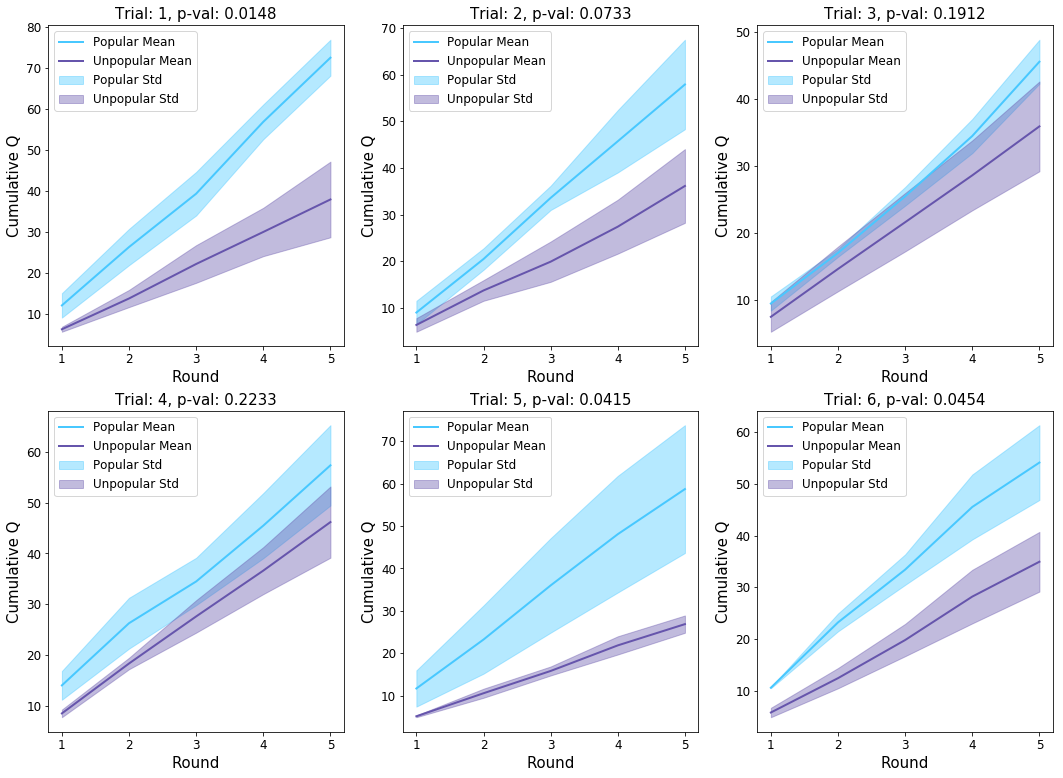

In [33]:
compute_temporal_boss_vs_lost_cq(comp)

### Link update regression

In [34]:
def my_regression(info_dict, choice='all'):
    x_u = []
    x_r = []
    x_q = []
    y = []
    
    x_up = []
    x_rp = []
    x_qp = []
    y_p = []
    
    for key,value in info_dict.items():
        y.append(value['y'])
        y_p.append(value['y_prime'])
        x_u.append(value['u'])
        x_up.append(value['u_prime'])
        x_r.append(value['r'])
        x_rp.append(value['r_prime'])
        x_q.append(value['q'])
        x_qp.append(value['q_prime'])

    X = np.column_stack((np.array(x_u),np.array(x_r),np.array(x_q)))
    X_p_u = np.array(x_up)
    X_p_r = np.array(x_rp)
    X_p_q = np.array(x_qp)
    X_p_ru = np.column_stack((np.array(x_rp),np.array(x_up)))
    X_p_uq = np.column_stack((np.array(x_up),np.array(x_qp)))
    X_p_rq = np.column_stack((np.array(x_rp),np.array(x_qp)))
    X_p_ruq = np.column_stack((np.array(x_rp),np.array(x_up),np.array(x_qp)))
    y_p = np.array(y_p)
    
    
    print("yp vs x_up")
    print(my_pearson(y_p, x_up))
    
    print("yp vs x_rp")
    print(my_pearson(y_p, x_rp))
    
    print("yp vs x_qp")
    print(my_pearson(y_p, x_qp))
    
    X_p_ruq = stats.zscore(X_p_ruq, axis=0)
    X_p_u = stats.zscore(X_p_u, axis=0)
    X_p_r = stats.zscore(X_p_r, axis=0)
    X_p_q = stats.zscore(X_p_q, axis=0)
    X_p_ru = stats.zscore(X_p_ru, axis=0)
    
    X_p_u = sm.add_constant(X_p_u)
    X_p_r = sm.add_constant(X_p_r)
    X_p_q = sm.add_constant(X_p_q)
    X_p_ru = sm.add_constant(X_p_ru)
    X_p_uq = sm.add_constant(X_p_uq)
    X_p_rq = sm.add_constant(X_p_rq)
    X_p_ruq = sm.add_constant(X_p_ruq)
    if choice=='all':
        X_chosen = X_p_ruq
    if choice=='r':
        X_chosen = X_p_r
    if choice=='ru':
        X_chosen = X_p_ru
    
    model = sm.OLS(y_p, X_chosen).fit()
    predictions = model.predict(X_chosen) # make the predictions by the model
    # Print out the statistics
    print(model.summary())

In [35]:
info_dict = my_regression_prep(comp)
my_regression(info_dict,'r')

yp vs x_up
(0.7985777912713857, 5.341909767060502e-09, 0.6372216297185818, 0.8928625227841426)
yp vs x_rp
(0.8585043575155645, 2.1551115577210464e-11, 0.7381657504646838, 0.9258935554578851)
yp vs x_qp
(0.746579491400668, 1.7112610810785052e-07, 0.5538999762865383, 0.8633551537242838)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     95.29
Date:                Tue, 19 Nov 2019   Prob (F-statistic):           2.16e-11
Time:                        02:52:40   Log-Likelihood:                 28.203
No. Observations:                  36   AIC:                            -52.41
Df Residuals:                      34   BIC:                            -49.24
Df Model:                           1                                         
Cov

In [36]:
info_dict = my_regression_prep(comp)
my_regression(info_dict,'ru')

yp vs x_up
(0.7985777912713857, 5.341909767060502e-09, 0.6372216297185818, 0.8928625227841426)
yp vs x_rp
(0.8585043575155645, 2.1551115577210464e-11, 0.7381657504646838, 0.9258935554578851)
yp vs x_qp
(0.746579491400668, 1.7112610810785052e-07, 0.5538999762865383, 0.8633551537242838)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     63.16
Date:                Tue, 19 Nov 2019   Prob (F-statistic):           5.22e-12
Time:                        02:52:41   Log-Likelihood:                 32.500
No. Observations:                  36   AIC:                            -59.00
Df Residuals:                      33   BIC:                            -54.25
Df Model:                           2                                         
Cov

In [37]:
info_dict = my_regression_prep(comp)
my_regression(info_dict,'all')

yp vs x_up
(0.7985777912713857, 5.341909767060502e-09, 0.6372216297185818, 0.8928625227841426)
yp vs x_rp
(0.8585043575155645, 2.1551115577210464e-11, 0.7381657504646838, 0.9258935554578851)
yp vs x_qp
(0.746579491400668, 1.7112610810785052e-07, 0.5538999762865383, 0.8633551537242838)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     44.76
Date:                Tue, 19 Nov 2019   Prob (F-statistic):           1.48e-11
Time:                        02:52:42   Log-Likelihood:                 33.823
No. Observations:                  36   AIC:                            -59.65
Df Residuals:                      32   BIC:                            -53.31
Df Model:                           3                                         
Cov

### Better alters -> better performance

One - None
$m_1=0.08$, $m_2=0.11$, $t(805)=-5.194$, $p=2.6120602737815943e-07$,
Bonferroni-corrected (uncorrected $p$-val $\times 3$) p=7.836180821344783e-07
$95\%$ C.I. for $m_1-m_2=[-0.042, -0.019]$
 
Both - One
$m_1=0.04$, $m_2=0.08$, $t(747)=-6.493$, $p=1.529861018310505e-10$,
Bonferroni-corrected (uncorrected $p$-val $\times 3$) p=4.5895830549315147e-10
$95\%$ C.I. for $m_1-m_2=[-0.043, -0.023]$
 
Both - None
$m_1=0.04$, $m_2=0.11$, $t(602)=-9.793$, $p=4.101879666931204e-21$,
Bonferroni-corrected (uncorrected $p$-val $\times 3$) p=1.2305639000793612e-20
$95\%$ C.I. for $m_1-m_2=[-0.076, -0.051]$
 


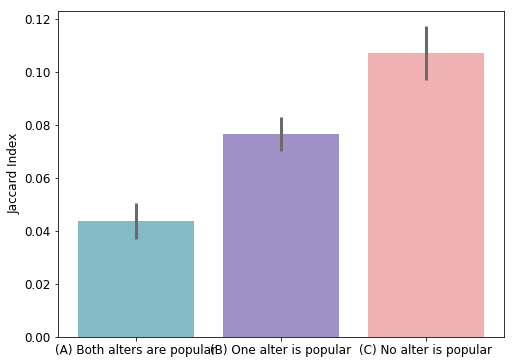

In [38]:
means=[]
conf=[]
plt.rc('figure', figsize = (8,6))
red=[]
green=[]
blue=[]
for trial_id in range(1,7):
    for round_id in range(1,6):
        for ego_id in comp.groups['ego_dy'][trial_id] :
            alters = comp.ego_followee_dict[ego_id][round_id]
            colorr = len(set(alters).intersection(comp.temporal_bosses[round_id]))
            avo = np.mean([compute_jaccard_index3(ego_id,k,round_id,comp) for k in alters])
            if colorr==0:
                red.append(avo)
            elif colorr==1:
                blue.append(avo)
            elif colorr==2:
                green.append(avo)
        
        for ego_id in comp.groups['ego_stat'][trial_id]:
            alters = comp.ego_stat_followee_list[ego_id]
            colorr = len(set(alters).intersection(comp.temporal_bosses_static[round_id]))
            avo = np.mean([compute_jaccard_index3(ego_id,k,round_id,comp) for k in alters])
            if colorr==0:
                red.append(avo)
            elif colorr==1:
                blue.append(avo)
            elif colorr==2:
                green.append(avo)

a=np.array(red)
b=np.array(blue)
c=np.array(green)
print("One - None")
full_t_test(b, a,3)
print(" ")
print("Both - One")
full_t_test(c, b,3)
print(" ")
print("Both - None")
full_t_test(c, a,3)
print(" ")

means.append(mean_confidence_interval(green)[0])
conf.append([mean_confidence_interval(green)[1],mean_confidence_interval(green)[2]])

means.append(mean_confidence_interval(blue)[0])
conf.append([mean_confidence_interval(blue)[1],mean_confidence_interval(blue)[2]])

means.append(mean_confidence_interval(red)[0])
conf.append([mean_confidence_interval(red)[1],mean_confidence_interval(red)[2]])

means=np.array(means)
conf=np.array(conf)
yerr = np.c_[means-conf[:,0],conf[:,1]-means ].T

plt.bar(range(len(means)), means, yerr=yerr,color=['#539caf','#7663b0','#EA9193'],alpha=0.7,error_kw=dict(ecolor='#6A6A6A',alpha=1, lw=3))
my_xticks = ['(A) Both alters are popular','(B) One alter is popular','(C) No alter is popular']
plt.xticks([0,1,2], my_xticks)
plt.ylabel('Jaccard Index')
plt.savefig('plots/jaccard_combined.eps', format='eps')  


One-None
$m_1=2.06$, $m_2=1.72$, $t(805)=3.751$, $p=0.00018908163153916232$,
Bonferroni-corrected (uncorrected $p$-val $\times 3$) p=0.0005672448946174869
$95\%$ C.I. for $m_1-m_2=[0.166, 0.528]$
 
Both-One
$m_1=1.96$, $m_2=2.06$, $t(747)=-1.115$, $p=0.2653069485813538$,
Bonferroni-corrected (uncorrected $p$-val $\times 3$) p=0.7959208457440614
$95\%$ C.I. for $m_1-m_2=[-0.295, 0.081]$
 
Both - None
$m_1=1.96$, $m_2=1.72$, $t(602)=2.403$, $p=0.016571669099622058$,
Bonferroni-corrected (uncorrected $p$-val $\times 3$) p=0.04971500729886617
$95\%$ C.I. for $m_1-m_2=[0.044, 0.436]$
 


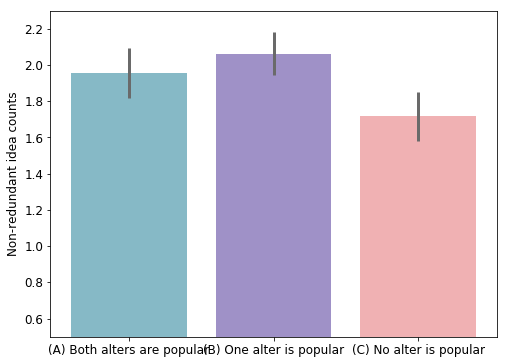

In [39]:
means=[]
conf=[]
plt.rc('figure', figsize = (8,6))
red=[]
green=[]
blue=[]
for trial_id in range(1,7):
    for round_id in range(1,6):
        for ego_id in comp.groups['ego_dy'][trial_id] :
            alters = comp.ego_followee_dict[ego_id][round_id]
            colorr = len(set(alters).intersection(comp.temporal_bosses[round_id]))
            avo = comp.unique_dict[ego_id][round_id][2]
            if colorr==0:
                red.append(avo)
            elif colorr==1:
                blue.append(avo)
            elif colorr==2:
                green.append(avo)
        for ego_id in comp.groups['ego_stat'][trial_id]:
            alters = comp.ego_stat_followee_list[ego_id]
            colorr = len(set(alters).intersection(comp.temporal_bosses_static[round_id]))
            avo = comp.unique_dict[ego_id][round_id][2]
            if colorr==0:
                red.append(avo)
            elif colorr==1:
                blue.append(avo)
            elif colorr==2:
                green.append(avo)

a=np.array(red)
b=np.array(blue)
c=np.array(green)
print("One-None")
full_t_test(b, a,3)
print(" ")
print("Both-One")
full_t_test(c, b,3)
print(" ")
print("Both - None")
full_t_test(c, a,3)
print(" ")
means.append(mean_confidence_interval(green)[0])
conf.append([mean_confidence_interval(green)[1],mean_confidence_interval(green)[2]])

means.append(mean_confidence_interval(blue)[0])
conf.append([mean_confidence_interval(blue)[1],mean_confidence_interval(blue)[2]])

means.append(mean_confidence_interval(red)[0])
conf.append([mean_confidence_interval(red)[1],mean_confidence_interval(red)[2]])

means=np.array(means)
conf=np.array(conf)
yerr = np.c_[means-conf[:,0],conf[:,1]-means ].T

plt.bar(range(len(means)), means, yerr=yerr,color=['#539caf','#7663b0','#EA9193'],alpha=0.7,error_kw=dict(ecolor='#6A6A6A',alpha=1, lw=3))
my_xticks = ['(A) Both alters are popular','(B) One alter is popular','(C) No alter is popular']
plt.xticks([0,1,2], my_xticks)
plt.ylabel('Non-redundant idea counts')
plt.ylim([0.5,2.3])
plt.savefig('plots/jaccard_t2_uniq_combined.eps', format='eps')  

One-None
$m_1=3.15$, $m_2=3.03$, $t(805)=3.345$, $p=0.0008596956557426987$,
Bonferroni-corrected (uncorrected $p$-val $\times 3$) p=0.002579086967228096
$95\%$ C.I. for $m_1-m_2=[0.047, 0.181]$
 
Both-One
$m_1=3.22$, $m_2=3.15$, $t(746)=1.995$, $p=0.046374994817469185$,
Bonferroni-corrected (uncorrected $p$-val $\times 3$) p=0.13912498445240756
$95\%$ C.I. for $m_1-m_2=[0.001, 0.145]$
 
Both - None
$m_1=3.22$, $m_2=3.03$, $t(601)=4.978$, $p=8.405643141615201e-07$,
Bonferroni-corrected (uncorrected $p$-val $\times 3$) p=2.5216929424845604e-06
$95\%$ C.I. for $m_1-m_2=[0.114, 0.262]$
 


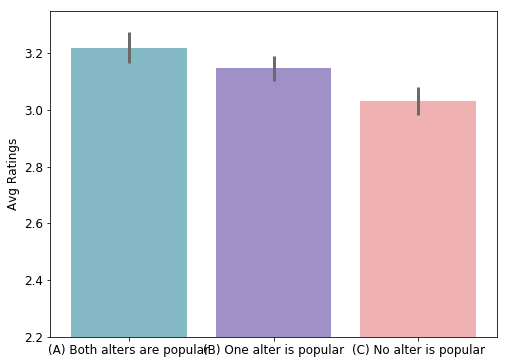

In [43]:
means=[]
conf=[]

plt.rc('figure', figsize = (8,6))

red=[]
green=[]
blue=[]
for trial_id in range(1,7):
    for round_id in range(1,6):
        for ego_id in comp.groups['ego_dy'][trial_id] :
            alters = comp.ego_followee_dict[ego_id][round_id]
            colorr = len(set(alters).intersection(comp.temporal_bosses[round_id]))
            avo = np.mean([rating for rating in comp.ratings_dict[ego_id][round_id][2]])
            if colorr==0 and not np.sum(np.isnan(avo)):
                red.append(avo)
            elif colorr==1 and not np.sum(np.isnan(avo)):
                blue.append(avo)
            elif colorr==2 and not np.sum(np.isnan(avo)):
                green.append(avo)
        for ego_id in comp.groups['ego_stat'][trial_id]:
            alters = comp.ego_stat_followee_list[ego_id]
            colorr = len(set(alters).intersection(comp.temporal_bosses_static[round_id]))
            avo = np.mean([rating for rating in comp.ratings_dict[ego_id][round_id][2]])
            if colorr==0 and not np.sum(np.isnan(avo)):
                red.append(avo)
            elif colorr==1 and not np.sum(np.isnan(avo)):
                blue.append(avo)
            elif colorr==2 and not np.sum(np.isnan(avo)):
                green.append(avo)
a=np.array(red)
b=np.array(blue)
c=np.array(green)
print("One-None")
full_t_test(b, a,3)
print(" ")
print("Both-One")
full_t_test(c, b,3)
print(" ")
print("Both - None")
full_t_test(c, a,3)
print(" ")
means.append(mean_confidence_interval(green)[0])
conf.append([mean_confidence_interval(green)[1],mean_confidence_interval(green)[2]])

means.append(mean_confidence_interval(blue)[0])
conf.append([mean_confidence_interval(blue)[1],mean_confidence_interval(blue)[2]])

means.append(mean_confidence_interval(red)[0])
conf.append([mean_confidence_interval(red)[1],mean_confidence_interval(red)[2]])

means=np.array(means)
conf=np.array(conf)
yerr = np.c_[means-conf[:,0],conf[:,1]-means ].T

plt.bar(range(len(means)), means, yerr=yerr,color=['#539caf','#7663b0','#EA9193'],alpha=0.7,error_kw=dict(ecolor='#6A6A6A',alpha=1, lw=3))
my_xticks = ['(A) Both alters are popular','(B) One alter is popular','(C) No alter is popular']
plt.xticks([0,1,2], my_xticks)
plt.ylabel('Avg Ratings')
plt.ylim([2.2,3.35])
plt.savefig('plots/jaccard_t2_ratings_combined.eps', format='eps')  


One-None
$m_1=6.61$, $m_2=5.7$, $t(805)=4.984$, $p=7.6228555640353e-07$,
Bonferroni-corrected (uncorrected $p$-val $\times 3$) p=2.28685666921059e-06
$95\%$ C.I. for $m_1-m_2=[0.557, 1.279]$
 
Both-One
$m_1=6.95$, $m_2=6.61$, $t(747)=1.693$, $p=0.09094856780311333$,
Bonferroni-corrected (uncorrected $p$-val $\times 3$) p=0.27284570340934
$95\%$ C.I. for $m_1-m_2=[-0.054, 0.737]$
 
Both - None
$m_1=6.95$, $m_2=5.7$, $t(602)=6.12$, $p=1.6857271787673687e-09$,
Bonferroni-corrected (uncorrected $p$-val $\times 3$) p=5.057181536302106e-09
$95\%$ C.I. for $m_1-m_2=[0.856, 1.663]$
 


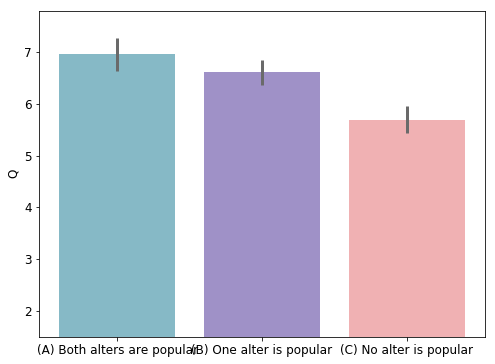

In [41]:
means=[]
conf=[]
plt.rc('figure', figsize = (8,6))
red=[]
green=[]
blue=[]
for trial_id in range(1,7):
    for round_id in range(1,6):
        for ego_id in comp.groups['ego_dy'][trial_id] :
            alters = comp.ego_followee_dict[ego_id][round_id]
            colorr = len(set(alters).intersection(comp.temporal_bosses[round_id]))
            avo = comp.cq_dict[ego_id][round_id][2]
            if colorr==0 and not np.sum(np.isnan(avo)):
                red.append(avo)
            elif colorr==1 and not np.sum(np.isnan(avo)):
                blue.append(avo)
            elif colorr==2 and not np.sum(np.isnan(avo)):
                green.append(avo)
        for ego_id in comp.groups['ego_stat'][trial_id]:
            alters = comp.ego_stat_followee_list[ego_id]
            colorr = len(set(alters).intersection(comp.temporal_bosses_static[round_id]))
            avo = comp.cq_dict[ego_id][round_id][2]
            if colorr==0 and not np.sum(np.isnan(avo)):
                red.append(avo)
            elif colorr==1 and not np.sum(np.isnan(avo)):
                blue.append(avo)
            elif colorr==2 and not np.sum(np.isnan(avo)):
                green.append(avo)

a=np.array(red)
b=np.array(blue)
c=np.array(green)
print("One-None")
full_t_test(b, a,3)
print(" ")
print("Both-One")
full_t_test(c, b,3)
print(" ")
print("Both - None")
full_t_test(c, a,3)
print(" ")
means.append(mean_confidence_interval(green)[0])
conf.append([mean_confidence_interval(green)[1],mean_confidence_interval(green)[2]])

means.append(mean_confidence_interval(blue)[0])
conf.append([mean_confidence_interval(blue)[1],mean_confidence_interval(blue)[2]])

means.append(mean_confidence_interval(red)[0])
conf.append([mean_confidence_interval(red)[1],mean_confidence_interval(red)[2]])

means=np.array(means)
conf=np.array(conf)
yerr = np.c_[means-conf[:,0],conf[:,1]-means ].T

plt.bar(range(len(means)), means, yerr=yerr,color=['#539caf','#7663b0','#EA9193'],alpha=0.7,error_kw=dict(ecolor='#6A6A6A',alpha=1, lw=3))
my_xticks = ['(A) Both alters are popular','(B) One alter is popular','(C) No alter is popular']
plt.xticks([0,1,2], my_xticks)
plt.ylabel('Q')
plt.ylim([1.5,7.8])
plt.savefig('plots/jaccard_t2_cq_combined.eps', format='eps')  


One-None
$m_1=0.1$, $m_2=0.13$, $t(150)=-2.207$, $p=0.028823582744543857$,
Bonferroni-corrected (uncorrected $p$-val $\times 3$) p=0.08647074823363157
$95\%$ C.I. for $m_1-m_2=[-0.054, -0.003]$
 
Both-One
$m_1=0.03$, $m_2=0.1$, $t(145)=-7.03$, $p=7.4969611253275e-11$,
Bonferroni-corrected (uncorrected $p$-val $\times 3$) p=2.24908833759825e-10
$95\%$ C.I. for $m_1-m_2=[-0.088, -0.050]$
 
Both-None
$m_1=0.03$, $m_2=0.13$, $t(131)=-8.223$, $p=1.7044088358179186e-13$,
Bonferroni-corrected (uncorrected $p$-val $\times 3$) p=5.113226507453756e-13
$95\%$ C.I. for $m_1-m_2=[-0.121, -0.074]$
 


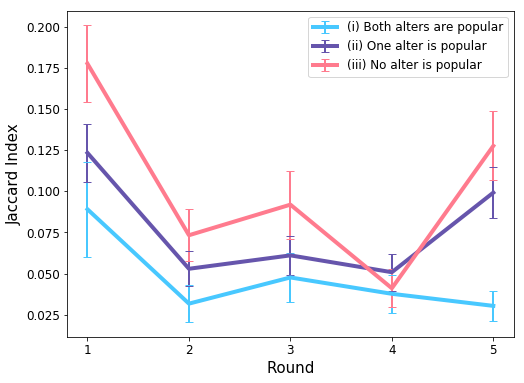

In [42]:
plt.rc('figure', figsize = (8,6))

means_r=[]
means_b=[]
means_g=[]
conf_r=[]
conf_b=[]
conf_g=[]

for round_id in range(1,6):
    red=[]
    green=[]
    blue=[]
    for ego_id in [id_ for trial_id in range(1,7) for id_ in comp.groups['ego_dy'][trial_id]]:
        alters = comp.ego_followee_dict[ego_id][round_id]
        colorr = len(set(alters).intersection(comp.temporal_bosses[round_id]))
        alters_s_list =[compute_jaccard_index3(ego_id,k,round_id,comp) for k in alters]
        avo = np.mean(alters_s_list)
        if colorr==0 :
            red.append(avo)
        elif colorr==1 :
            blue.append(avo)
        elif colorr==2:
            green.append(avo)

    for ego_id in [id_ for trial_id in range(1,7) for id_ in comp.groups['ego_stat'][trial_id]]:
        alters = comp.ego_stat_followee_list[ego_id]
        colorr = len(set(alters).intersection(comp.temporal_bosses_static[round_id]))
        alters_s_list =[compute_jaccard_index3(ego_id,k,round_id,comp) for k in alters]
        avo = np.mean(alters_s_list)
        if colorr==0:
            red.append(avo)
        elif colorr==1:
            blue.append(avo)
        elif colorr==2:
            green.append(avo)
    if round_id==5:
        aa=np.array(red)
        bb=np.array(blue)
        print("One-None")
        full_t_test(bb, aa,3)
        print(" ")
        
        aa=np.array(blue)
        bb=np.array(green)
        print("Both-One")
        full_t_test(bb, aa,3)
        print(" ")
        
        aa=np.array(green)
        bb=np.array(red)
        print("Both-None")
        full_t_test(aa, bb,3)
        print(" ")

    means_r.append(mean_confidence_interval(red)[0])
    conf_r.append([mean_confidence_interval(red)[1],mean_confidence_interval(red)[2]])

    means_b.append(mean_confidence_interval(blue)[0])
    conf_b.append([mean_confidence_interval(blue)[1],mean_confidence_interval(blue)[2]])

    means_g.append(mean_confidence_interval(green)[0])
    conf_g.append([mean_confidence_interval(green)[1],mean_confidence_interval(green)[2]])

means_r=np.array(means_r)
means_b=np.array(means_b)
means_g=np.array(means_g)

conf_r=np.array(conf_r)
conf_b=np.array(conf_b)
conf_g=np.array(conf_g)
yerr_r = np.c_[means_r-conf_r[:,0],conf_r[:,1]-means_r ].T
yerr_b = np.c_[means_b-conf_b[:,0],conf_b[:,1]-means_b ].T
yerr_g = np.c_[means_g-conf_g[:,0],conf_g[:,1]-means_g ].T

plt.errorbar(range(len(means_g)), means_g, yerr=yerr_g, color = '#48c8ff',fmt='-',capsize=4,elinewidth=2,lw=4,label = '(i) Both alters are popular')
plt.errorbar(range(len(means_b)), means_b, yerr=yerr_b, color = '#6655ac',fmt='-',capsize=4,elinewidth=2,lw=4,label = '(ii) One alter is popular')
plt.errorbar(range(len(means_r)), means_r, yerr=yerr_r, color = '#ff7b8e',fmt='-',capsize=4,elinewidth=2,lw=4,label = '(iii) No alter is popular')

plt.ylabel('Jaccard Index',fontsize=15)
plt.legend(loc = 'upper right')
plt.xticks([0,1,2,3,4],[1,2,3,4,5])
plt.xlabel("Round",fontsize=15)
plt.savefig('plots/jaccard_roundwise_v2.eps', format='eps')   

### Same alters -> inter-ego redundancy

In [45]:
def generate_projected_plot(comp,plot_=None):
    adjacency_dict = generate_adjacency(comp)
    ego_index = [i for i in range(6,24)]
    
    projected_dict={}
    for trial_id in adjacency_dict:
        projected_dict[trial_id]={}
        if plot_:
            plt.rc('figure', figsize = (18,12))
        for round_id in range(0,6):
            if plot_:
                plt.subplot(2,3,round_id+1);
            a = adjacency_dict[trial_id][:,:,round_id]
            p = np.hstack((np.zeros((6,6)),a))
            q = np.hstack((np.transpose(a),(np.zeros((18,18)))))
            A = np.vstack((p,q))
            G = nx.from_numpy_matrix(A)
            
            proj = bipartite.weighted_projected_graph(G,ego_index)
            
            mapping={}
            for index, i in enumerate(range(6,24)):
                mapping[i]=comp.groups['ego_dy'][trial_id][index]

            proj=nx.relabel_nodes(proj,mapping)

            projected_dict[trial_id][round_id]=proj
            
            if plot_:
                pos=nx.spring_layout(proj) 
                nx.draw_networkx_nodes(proj,pos,label=ego_index)
                nx.draw_networkx_labels(proj,pos,label=ego_index)

                all_weights = []
                for (node1,node2,data) in proj.edges(data=True):
                    all_weights.append(data['weight'])

                unique_weights = list(set(all_weights))
                edge_color_set = ['c','m']
                for weight in unique_weights:
                    weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in proj.edges(data=True) if edge_attr['weight']==weight]
                    width = weight*18*5.0/sum(all_weights)
                    nx.draw_networkx_edges(proj,pos,edgelist=weighted_edges,width=width,edge_color=edge_color_set[weight-1])
                plt.axis('off')
                plt.title('Round: '+str(round_id))
        if plot_:
            plt.savefig("plots/trial_dynamic_"+str(trial_id)+".eps") 
            plt.show()
    return projected_dict       


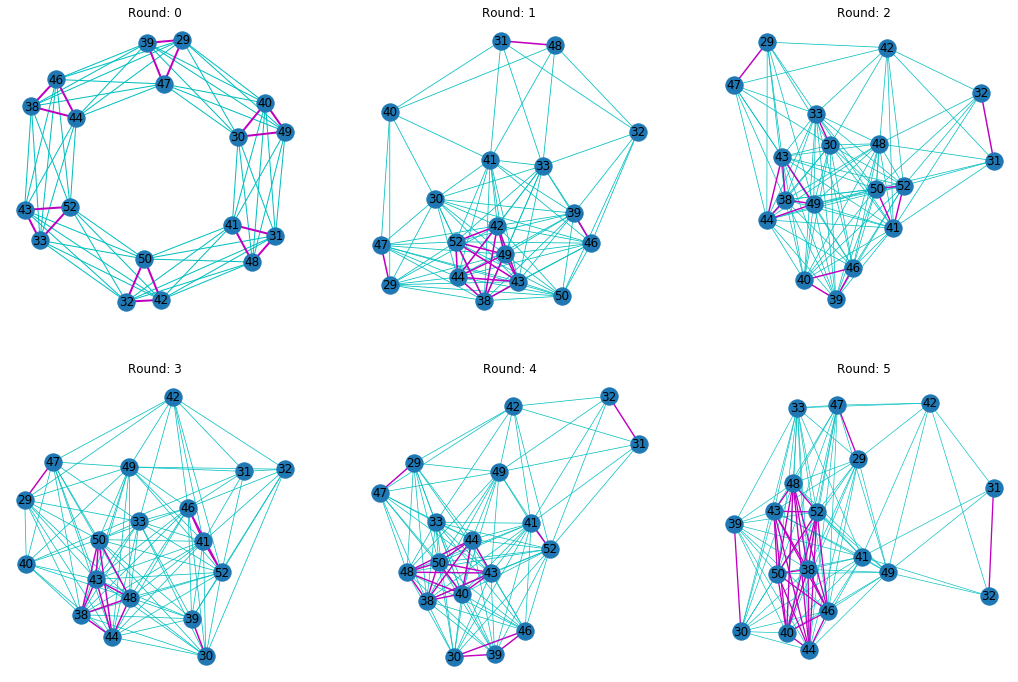

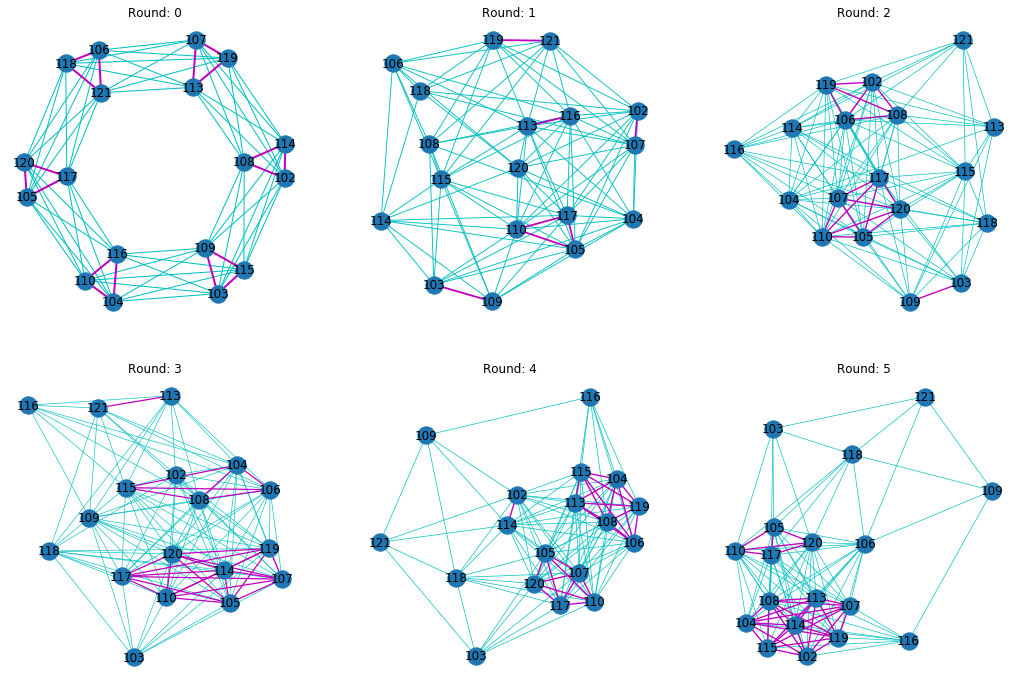

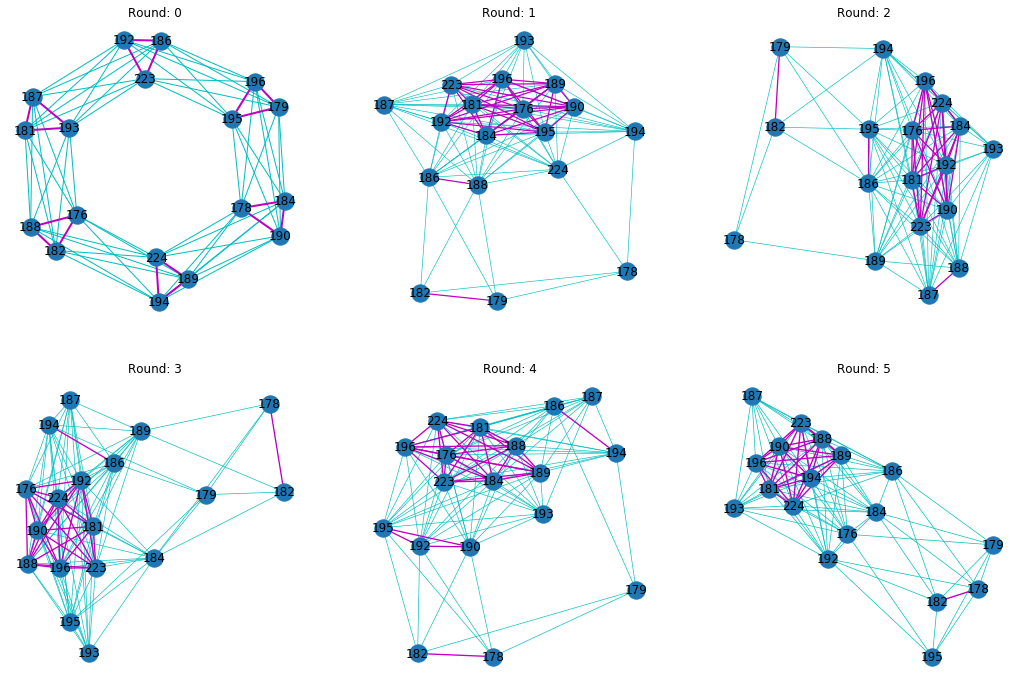

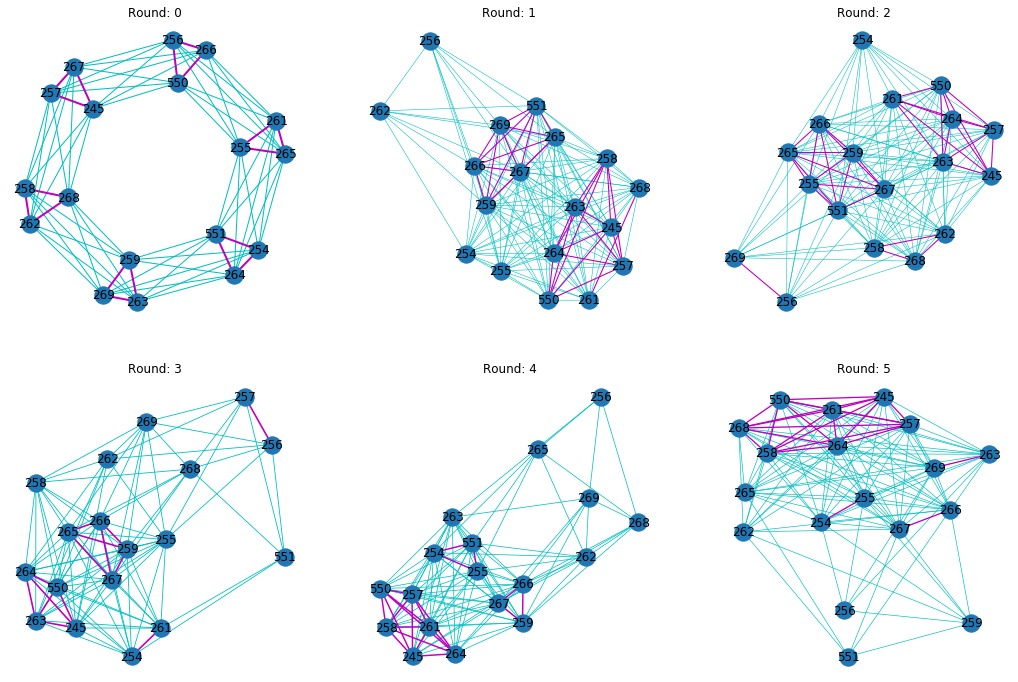

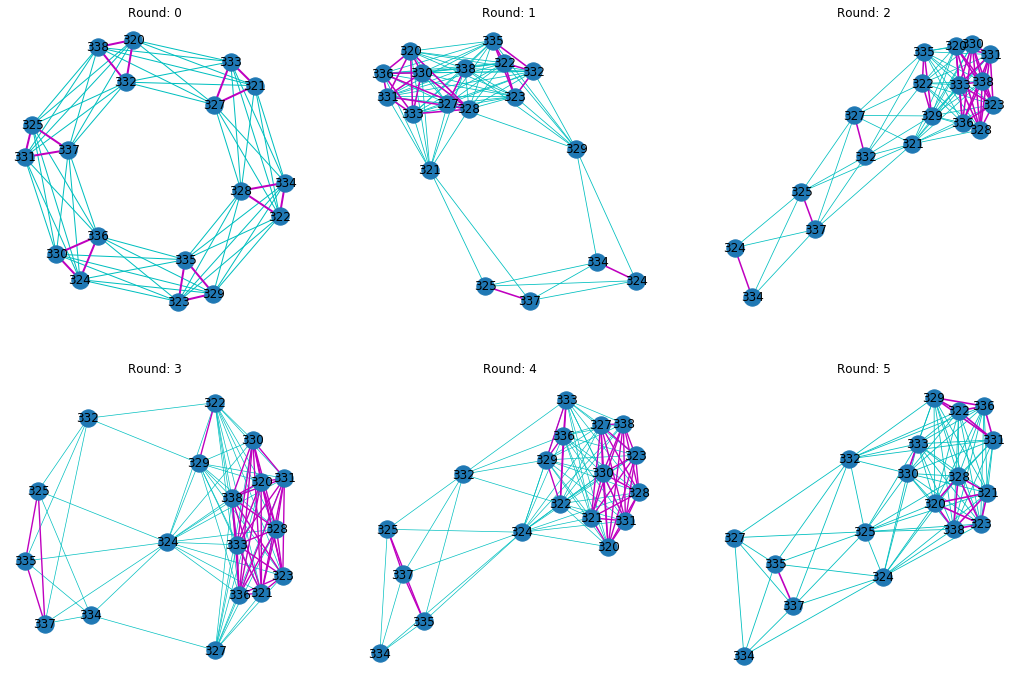

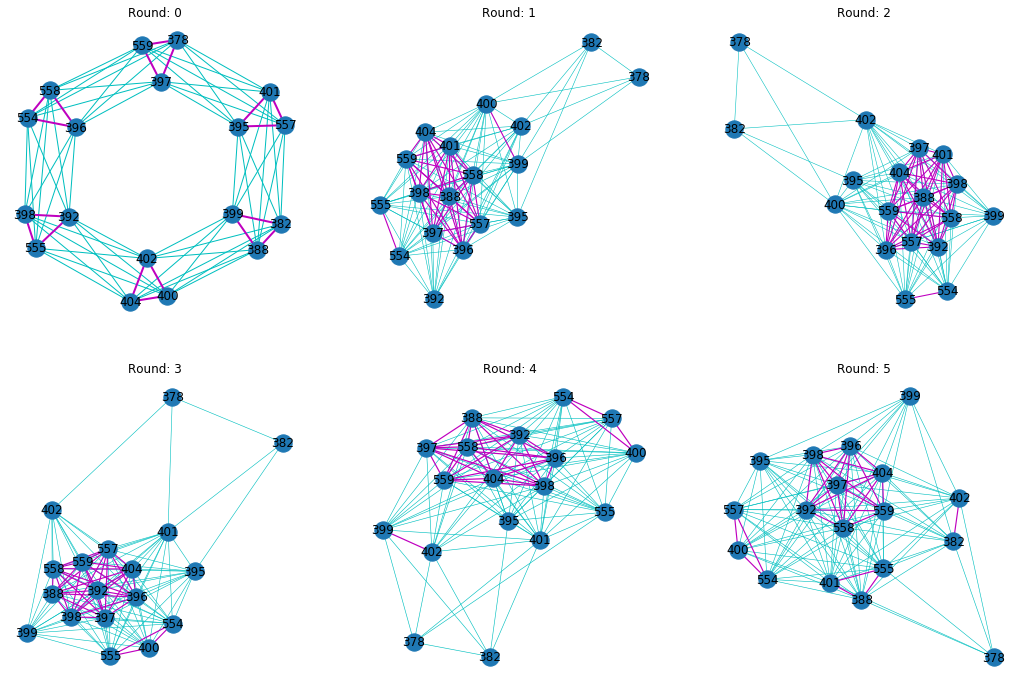

In [46]:
projected_dict = generate_projected_plot(comp,True)

In [47]:
def compute_similarity_collection2(comp):
    collection_similarity = {}
    projected_dict = generate_projected_plot(comp)
    
    for trial_id in range(1,7):
        print("trial: "+str(trial_id))
        collection_similarity[trial_id]={}
        
        for round_id in range(1,6): #round 0's (init) network structure used in round 1, etc, so round 5's end structure is never used
            collection_similarity[trial_id][round_id]={'sim0':[],'sim1':[],'sim2':[]}
            temp_graph = projected_dict[trial_id][round_id-1]
            nodes_list = list(temp_graph.nodes())
            edges_list = list(temp_graph.edges(data=False))
            for n1,n2,w in list(temp_graph.edges(data=True)):
                if w['weight']==1:
                    collection_similarity[trial_id][round_id]['sim1'].append(compute_wmd_distance2(n1,n2,round_id,comp))
                if w['weight']==2:
                    collection_similarity[trial_id][round_id]['sim2'].append(compute_wmd_distance2(n1,n2,round_id,comp))
            
            for t1,t2 in list(itertools.combinations(nodes_list, 2)): #iterate over all possible edges
                if (t1,t2) not in edges_list and (t2,t1) not in edges_list: #this is a weight 0 or 'missing' edge
                    collection_similarity[trial_id][round_id]['sim0'].append(compute_wmd_distance2(t1,t2,round_id,comp))
                    
    return collection_similarity

In [48]:
collection_similarity_wmd_dy = compute_similarity_collection2(comp)

trial: 1
trial: 2
trial: 3
trial: 4
trial: 5
trial: 6


s2-s0
$m_1=3.01$, $m_2=3.22$, $t(452)=-2.962$, $p=0.003217269459769723$,
Bonferroni-corrected (uncorrected $p$-val $\times 3$) p=0.009651808379309169
$95\%$ C.I. for $m_1-m_2=[-0.360, -0.073]$
 
s2-s1
$m_1=3.01$, $m_2=3.19$, $t(632)=-2.788$, $p=0.005467491113007128$,
Bonferroni-corrected (uncorrected $p$-val $\times 3$) p=0.01640247333902138
$95\%$ C.I. for $m_1-m_2=[-0.309, -0.054]$
 


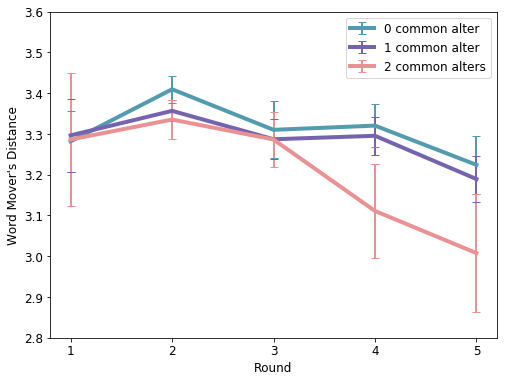

In [49]:
plt.rc('figure', figsize = (8,6))
means_s0=[]
means_s1=[]
means_s2=[]
conf_s0=[]
conf_s1=[]
conf_s2=[]

for round_id in range(1,6):
    s0 = [i for trial_id in collection_similarity_wmd_dy for i in collection_similarity_wmd_dy[trial_id][round_id]['sim0']]
    s1 = [i for trial_id in collection_similarity_wmd_dy for i in collection_similarity_wmd_dy[trial_id][round_id]['sim1']]
    s2 = [i for trial_id in collection_similarity_wmd_dy for i in collection_similarity_wmd_dy[trial_id][round_id]['sim2']]
    if round_id==5:
        a0=np.array(s0)
        a1=np.array(s1)
        a2=np.array(s2)
        print("s2-s0")
        full_t_test(a2,a0,3)
        print(" ")
        print("s2-s1")
        full_t_test(a2,a1,3)
        print(" ")
    means_s0.append(mean_confidence_interval(s0)[0])
    conf_s0.append([mean_confidence_interval(s0)[1],mean_confidence_interval(s0)[2]])

    means_s1.append(mean_confidence_interval(s1)[0])
    conf_s1.append([mean_confidence_interval(s1)[1],mean_confidence_interval(s1)[2]])

    means_s2.append(mean_confidence_interval(s2)[0])
    conf_s2.append([mean_confidence_interval(s2)[1],mean_confidence_interval(s2)[2]])
        
means_s0=np.array(means_s0)
means_s1=np.array(means_s1)
means_s2=np.array(means_s2)
conf_s0=np.array(conf_s0)
conf_s1=np.array(conf_s1)
conf_s2=np.array(conf_s2)
yerr_s0 = np.c_[means_s0-conf_s0[:,0],conf_s0[:,1]-means_s0 ].T
yerr_s1 = np.c_[means_s1-conf_s1[:,0],conf_s1[:,1]-means_s1 ].T
yerr_s2 = np.c_[means_s2-conf_s2[:,0],conf_s2[:,1]-means_s2 ].T
plt.errorbar(range(len(means_s0)), means_s0, yerr=yerr_s0, color = '#539caf',fmt='-',capsize=4,elinewidth=2,lw=4,label = '0 common alter')
plt.errorbar(range(len(means_s1)), means_s1, yerr=yerr_s1, color = '#7663b0',fmt='-',capsize=4,elinewidth=2,lw=4,label = '1 common alter')
plt.errorbar(range(len(means_s2)), means_s2, yerr=yerr_s2, color = '#EA9193',fmt='-',capsize=4,elinewidth=2,lw=4,label = '2 common alters')
plt.legend(loc = 'upper right')
plt.ylim([2.8,3.6])
plt.xticks([0,1,2,3,4],[1,2,3,4,5])
plt.xlabel("Round")
plt.ylabel("Word Mover's Distance")
plt.savefig('plots/WMD_comb.eps', format='eps')       

In [50]:
def generate_static_projected_plot(comp,plot_=None):
    adjacency_dict = generate_adjacency_static(comp)
    ego_index = [i for i in range(6,24)]
    
    projected_dict={}
    for trial_id in adjacency_dict:
        projected_dict[trial_id]={}
        if plot_:
            plt.rc('figure', figsize = (18,12))
        for round_id in range(0,6):
            if plot_:
                plt.subplot(2,3,round_id+1);
            a = adjacency_dict[trial_id][:,:,round_id]
            p = np.hstack((np.zeros((6,6)),a))
            q = np.hstack((np.transpose(a),(np.zeros((18,18)))))
            A = np.vstack((p,q))
            G = nx.from_numpy_matrix(A)
            proj = bipartite.weighted_projected_graph(G,ego_index)   
            
            mapping={}
            for index, i in enumerate(range(6,24)):
                mapping[i]=comp.groups['ego_stat'][trial_id][index]
            proj=nx.relabel_nodes(proj,mapping)

            projected_dict[trial_id][round_id]=proj
            
            if plot_:
                pos=nx.spring_layout(proj) 
                nx.draw_networkx_nodes(proj,pos,label=ego_index)
                nx.draw_networkx_labels(proj,pos,label=ego_index)

                all_weights = []
                for (node1,node2,data) in proj.edges(data=True):
                    all_weights.append(data['weight'])

                unique_weights = list(set(all_weights))
                edge_color_set = ['c','m']
                for weight in unique_weights:
                    weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in proj.edges(data=True) if edge_attr['weight']==weight]
                    width = weight*18*5.0/sum(all_weights)
                    nx.draw_networkx_edges(proj,pos,edgelist=weighted_edges,width=width,edge_color=edge_color_set[weight-1])
                plt.axis('off')
                plt.title('Round: '+str(round_id))
        if plot_:
            plt.savefig("trial_"+str(trial_id)+".eps") 
            plt.show()
    return projected_dict       

In [51]:
def compute_similarity_collection_static(comp):
    collection_similarity = {}
    projected_dict = generate_static_projected_plot(comp)
    
    for trial_id in range(1,7):
        print("trial: "+str(trial_id))
        collection_similarity[trial_id]={}
        
        for round_id in range(1,6): #round 0's (init) network structure used in round 1, etc, so round 5's end structure is never used
            collection_similarity[trial_id][round_id]={'sim0':[],'sim1':[],'sim2':[]}
            temp_graph = projected_dict[trial_id][round_id-1]
            nodes_list = list(temp_graph.nodes())
            edges_list = list(temp_graph.edges(data=False))
            
            for n1,n2,w in list(temp_graph.edges(data=True)):
                
                if w['weight']==1:
                    collection_similarity[trial_id][round_id]['sim1'].append(compute_wmd_distance2(n1,n2,round_id,comp))
                if w['weight']==2:
                    collection_similarity[trial_id][round_id]['sim2'].append(compute_wmd_distance2(n1,n2,round_id,comp))
            
            for t1,t2 in list(itertools.combinations(nodes_list, 2)): #iterate over all possible edges
                if (t1,t2) not in edges_list and (t2,t1) not in edges_list: #this is a weight 0 or 'missing' edge
                    collection_similarity[trial_id][round_id]['sim0'].append(compute_wmd_distance2(t1,t2,round_id,comp))

    return collection_similarity

In [52]:
collection_similarity_static = compute_similarity_collection_static(comp)

trial: 1
trial: 2
trial: 3
trial: 4
trial: 5
trial: 6


0.5411309656278201 0.6114582646572458


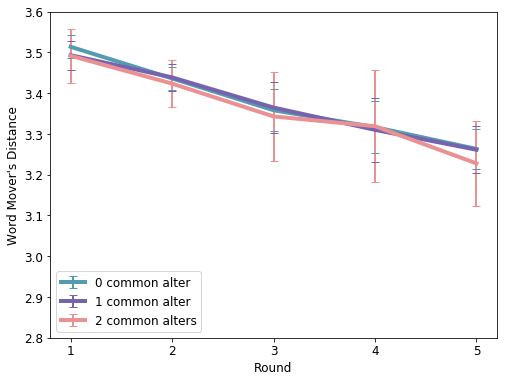

In [53]:
plt.rc('figure', figsize = (8,6))
means_s0=[]
means_s1=[]
means_s2=[]
conf_s0=[]
conf_s1=[]
conf_s2=[]

for round_id in range(1,6):
    s0 = [i for trial_id in collection_similarity_static for i in collection_similarity_static[trial_id][round_id]['sim0']]
    s1 = [i for trial_id in collection_similarity_static for i in collection_similarity_static[trial_id][round_id]['sim1']]
    s2 = [i for trial_id in collection_similarity_static for i in collection_similarity_static[trial_id][round_id]['sim2']]
    if round_id==5:
        aa=np.array(s0)
        bb=np.array(s2)
        t, p = stats.ttest_ind(aa,bb)
        print(p,t)
    means_s0.append(mean_confidence_interval(s0)[0])
    conf_s0.append([mean_confidence_interval(s0)[1],mean_confidence_interval(s0)[2]])

    means_s1.append(mean_confidence_interval(s1)[0])
    conf_s1.append([mean_confidence_interval(s1)[1],mean_confidence_interval(s1)[2]])

    means_s2.append(mean_confidence_interval(s2)[0])
    conf_s2.append([mean_confidence_interval(s2)[1],mean_confidence_interval(s2)[2]])
               
means_s0=np.array(means_s0)
means_s1=np.array(means_s1)
means_s2=np.array(means_s2)
conf_s0=np.array(conf_s0)
conf_s1=np.array(conf_s1)
conf_s2=np.array(conf_s2)
yerr_s0 = np.c_[means_s0-conf_s0[:,0],conf_s0[:,1]-means_s0 ].T
yerr_s1 = np.c_[means_s1-conf_s1[:,0],conf_s1[:,1]-means_s1 ].T
yerr_s2 = np.c_[means_s2-conf_s2[:,0],conf_s2[:,1]-means_s2 ].T
plt.errorbar(range(len(means_s0)), means_s0, yerr=yerr_s0, color = '#539caf',fmt='-',capsize=4,elinewidth=2,lw=4,label = '0 common alter')
plt.errorbar(range(len(means_s1)), means_s1, yerr=yerr_s1, color = '#7663b0',fmt='-',capsize=4,elinewidth=2,lw=4,label = '1 common alter')
plt.errorbar(range(len(means_s2)), means_s2, yerr=yerr_s2, color = '#EA9193',fmt='-',capsize=4,elinewidth=2,lw=4,label = '2 common alters')
plt.legend(loc = 'lower left')
plt.ylim([2.8,3.6])
plt.xticks([0,1,2,3,4],[1,2,3,4,5])
plt.xlabel("Round")
plt.ylabel("Word Mover's Distance")
plt.savefig('plots/WMD_static.eps', format='eps')  

In [54]:
def compute_similarity_collection_crowd(comp):
    collection_similarity = {}
    all_crowd_ids = [i for group in comp.groups['crowd'] for i in comp.groups['crowd'][group]]
    
    for round_id in range(1,6): #round 0's (init) network structure used in round 1, etc, so round 5's end structure is never used
        print("round: "+str(round_id))
        collection_similarity[round_id]={'sim0':[],'sim1':[],'sim2':[]}
        for n1,n2 in itertools.combinations(all_crowd_ids,2):
            collection_similarity[round_id]['sim0'].append(compute_wmd_distance3(n1,n2,round_id,comp))
    return collection_similarity

In [55]:
collection_similarity_crowd = compute_similarity_collection_crowd(comp)

round: 1
round: 2
round: 3
round: 4
round: 5


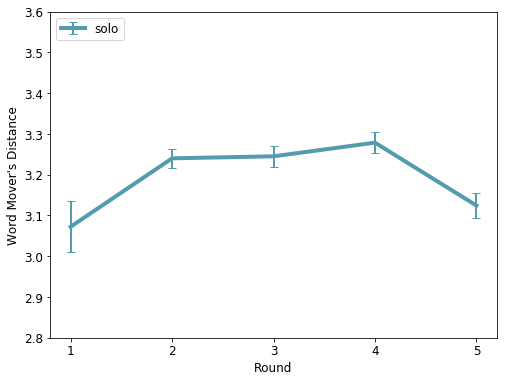

In [56]:
plt.rc('figure', figsize = (8,6))
means_s0=[]
means_s1=[]
means_s2=[]
conf_s0=[]
conf_s1=[]
conf_s2=[]

for round_id in range(1,6):
    s0 = [i  for i in collection_similarity_crowd[round_id]['sim0']]
    means_s0.append(mean_confidence_interval(s0)[0])
    conf_s0.append([mean_confidence_interval(s0)[1],mean_confidence_interval(s0)[2]]) 
means_s0=np.array(means_s0)
conf_s0=np.array(conf_s0)
yerr_s0 = np.c_[means_s0-conf_s0[:,0],conf_s0[:,1]-means_s0 ].T

plt.errorbar(range(len(means_s0)), means_s0, yerr=yerr_s0, color = '#539caf',fmt='-',capsize=4,elinewidth=2,lw=4,label = 'solo')
plt.legend(loc = 'upper left')
plt.ylim([2.8,3.6])
plt.xticks([0,1,2,3,4],[1,2,3,4,5])
plt.xlabel("Round")
plt.ylabel("Word Mover's Distance")
plt.savefig('plots/WMD_crowd.eps', format='eps')   

### Individual performance comparisons among conditions

### Aggregated

In [57]:
def compute_lumped_temporal_cr_vs_st_vs_dy_uniq(comp):
    plt.rc('figure', figsize = (8,6))
    means_s=[]
    conf_s=[]
    means_d=[]
    conf_d=[]
    means_c=[]
    conf_c=[]
    for round_ in range(1,6):
        static_list = [np.sum([comp.overall_unique_dict[id_][round__][1]+comp.overall_unique_dict[id_][round__][2] for round__ in range(1,round_+1)]) for trial_id in comp.groups['ego_stat'] for id_ in comp.groups['ego_stat'][trial_id]]
        dynamic_list = [np.sum([comp.overall_unique_dict[id_][round__][1]+comp.overall_unique_dict[id_][round__][2] for round__ in range(1,round_+1)]) for trial_id in comp.groups['ego_dy'] for id_ in comp.groups['ego_dy'][trial_id]]
        crowd_list = [np.sum([comp.overall_unique_dict[id_][round__][1]+comp.overall_unique_dict[id_][round__][2] for round__ in range(1,round_+1)]) for trial_id in comp.groups['crowd'] for id_ in comp.groups['crowd'][trial_id]]      
        
        means_s.append(mean_confidence_interval(static_list)[0])
        conf_s.append([mean_confidence_interval(static_list)[1],mean_confidence_interval(static_list)[2]])
                     
        means_d.append(mean_confidence_interval(dynamic_list)[0])
        conf_d.append([mean_confidence_interval(dynamic_list)[1],mean_confidence_interval(dynamic_list)[2]])
                     
        means_c.append(mean_confidence_interval(crowd_list)[0])
        conf_c.append([mean_confidence_interval(crowd_list)[1],mean_confidence_interval(crowd_list)[2]])
        
        if round_==5:
            aa=np.array(crowd_list)
            bb=np.array(dynamic_list)
            print("dynamic-crowd")
            full_t_test(bb,aa,3)
            print(" ")
            aa=np.array(crowd_list)
            bb=np.array(static_list)
            print("static-crowd")
            full_t_test(bb,aa,3)
            print(" ")
            aa=np.array(dynamic_list)
            bb=np.array(static_list)
            print("dynamic static")
            full_t_test(aa,bb,3)
            print(" ")
    
    means_s=np.array(means_s)
    means_d=np.array(means_d)
    means_c=np.array(means_c)
    conf_s=np.array(conf_s)
    conf_d=np.array(conf_d)
    conf_c=np.array(conf_c)
    yerr_s = np.c_[means_s-conf_s[:,0],conf_s[:,1]-means_s ].T
    yerr_d = np.c_[means_d-conf_d[:,0],conf_d[:,1]-means_d ].T
    yerr_c = np.c_[means_c-conf_c[:,0],conf_c[:,1]-means_c ].T
    
    _, ax1 = plt.subplots()
    ax1.errorbar(range(len(means_s)), means_s, yerr=yerr_s, color = '#539caf',fmt='-',capsize=4,elinewidth=2,lw=4,label = 'Static')
    ax1.errorbar(range(len(means_d)), means_d, yerr=yerr_d, color = '#7663b0',fmt='-',capsize=4,elinewidth=2,lw=4,label = 'Dynamic')
    ax1.errorbar(range(len(means_c)), means_c, yerr=yerr_c, color = '#EA9193',fmt='-',capsize=4,elinewidth=2,lw=4,label = 'Solo')

    ax1.set_title("Cumulative non-redundant ideas")
    ax1.set_xlabel("Round")
    ax1.set_ylabel("Cumulative non-redundant ideas")
    ax1.legend(loc = 'upper left')
    plt.xticks([0,1,2,3,4],[1,2,3,4,5])
    plt.savefig('plots/individual_comparisons_uniq.eps', format='eps')   
    

dynamic-crowd
$m_1=6.33$, $m_2=4.44$, $t(142)=2.7$, $p=0.00778382525447493$,
Bonferroni-corrected (uncorrected $p$-val $\times 3$) p=0.023351475763424792
$95\%$ C.I. for $m_1-m_2=[0.515, 3.263]$
 
static-crowd
$m_1=6.77$, $m_2=4.44$, $t(142)=2.898$, $p=0.004354188361922472$,
Bonferroni-corrected (uncorrected $p$-val $\times 3$) p=0.013062565085767416
$95\%$ C.I. for $m_1-m_2=[0.749, 3.899]$
 
dynamic static
$m_1=6.33$, $m_2=6.77$, $t(214)=-0.795$, $p=0.42739171047643376$,
Bonferroni-corrected (uncorrected $p$-val $\times 3$) p=1.2821751314293013
$95\%$ C.I. for $m_1-m_2=[-1.509, 0.639]$
 


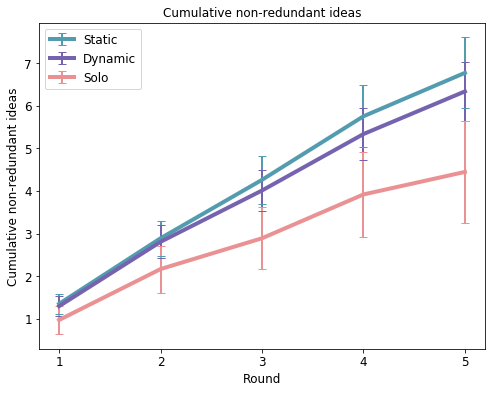

In [58]:
compute_lumped_temporal_cr_vs_st_vs_dy_uniq(comp)

In [59]:
def compute_cr_vs_st_vs_dy_rating(comp):
    plt.rc('figure', figsize = (8,6))
    means=[]
    conf=[]
    static_list = [np.mean([r for round_ in range(1,6) for r in comp.ratings_dict[id_][round_][1]+comp.ratings_dict[id_][round_][2]]) for trial_id in comp.groups['ego_stat'] for id_ in comp.groups['ego_stat'][trial_id]]
    dynamic_list = [np.mean([r for round_ in range(1,6) for r in comp.ratings_dict[id_][round_][1]+comp.ratings_dict[id_][round_][2]]) for trial_id in comp.groups['ego_dy'] for id_ in comp.groups['ego_dy'][trial_id]]
    crowd_list = [np.mean([r for round_ in range(1,6) for r in comp.ratings_dict[id_][round_][1]+comp.ratings_dict[id_][round_][2]]) for trial_id in comp.groups['crowd'] for id_ in comp.groups['crowd'][trial_id]]
    
    a=np.array(crowd_list)
    b=np.array(dynamic_list)
    c=np.array(static_list)
    print("crowd - dynamic")
    full_t_test(a,b,3)
    print(" ")
    print("dynamic - static")
    full_t_test(b,c,3)
    print(" ")
    print("static - crowd")
    full_t_test(c,a,3)
    print(" ")
    
    means.append(mean_confidence_interval(static_list)[0])
    conf.append([mean_confidence_interval(static_list)[1],mean_confidence_interval(static_list)[2]])

    means.append(mean_confidence_interval(dynamic_list)[0])
    conf.append([mean_confidence_interval(dynamic_list)[1],mean_confidence_interval(dynamic_list)[2]])
    
    means.append(mean_confidence_interval(crowd_list)[0])
    conf.append([mean_confidence_interval(crowd_list)[1],mean_confidence_interval(crowd_list)[2]])
    
    means=np.array(means)
    conf=np.array(conf)
    yerr = np.c_[means-conf[:,0],conf[:,1]-means ].T

    plt.bar(range(len(means)), means, yerr=yerr,color=['#539caf','#7663b0','#EA9193'],alpha=0.7,error_kw=dict(ecolor='#6A6A6A',alpha=1, lw=3))
    my_xticks = ['Static','Dynamic','Solo']
    plt.xticks([0,1,2], my_xticks)
    plt.ylabel('Average rating')
    plt.ylim([2.6,3.2])
    plt.savefig('plots/individual_comparisons_ratings.eps', format='eps')  


crowd - dynamic
$m_1=3.06$, $m_2=3.09$, $t(142)=-0.692$, $p=0.49014969255829177$,
Bonferroni-corrected (uncorrected $p$-val $\times 3$) p=1.4704490776748753
$95\%$ C.I. for $m_1-m_2=[-0.108, 0.052]$
 
dynamic - static
$m_1=3.09$, $m_2=3.03$, $t(214)=2.1$, $p=0.036933120591358115$,
Bonferroni-corrected (uncorrected $p$-val $\times 3$) p=0.11079936177407435
$95\%$ C.I. for $m_1-m_2=[0.004, 0.109]$
 
static - crowd
$m_1=3.03$, $m_2=3.06$, $t(142)=-0.806$, $p=0.42144592960567995$,
Bonferroni-corrected (uncorrected $p$-val $\times 3$) p=1.26433778881704
$95\%$ C.I. for $m_1-m_2=[-0.096, 0.040]$
 


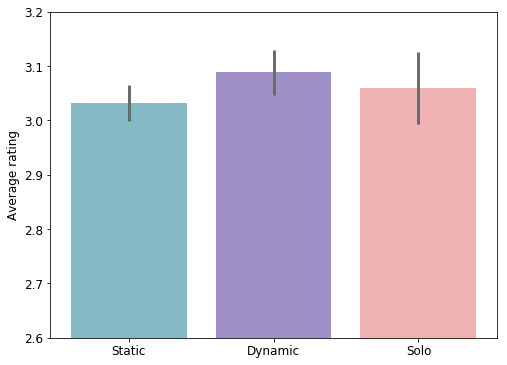

In [60]:
compute_cr_vs_st_vs_dy_rating(comp)

In [61]:
def compute_lumped_temporal_cr_vs_st_vs_dy_cq(comp):
    plt.rc('figure', figsize = (8,6))
    means_s=[]
    conf_s=[]    
    means_d=[]
    conf_d=[]
    means_c=[]
    conf_c=[]
    for round_ in range(1,6):
        static_list = [np.sum([comp.cq_dict[id_][round__]['both'] for round__ in range(1,round_+1)]) for trial_id in comp.groups['ego_stat'] for id_ in comp.groups['ego_stat'][trial_id]]
        dynamic_list = [np.sum([comp.cq_dict[id_][round__]['both'] for round__ in range(1,round_+1)]) for trial_id in comp.groups['ego_dy'] for id_ in comp.groups['ego_dy'][trial_id]]
        crowd_list = [np.sum([comp.cq_dict[id_][round__]['both'] for round__ in range(1,round_+1)]) for trial_id in comp.groups['crowd'] for id_ in comp.groups['crowd'][trial_id]]
        
        means_s.append(mean_confidence_interval(static_list)[0])
        conf_s.append([mean_confidence_interval(static_list)[1],mean_confidence_interval(static_list)[2]])
                     
        means_d.append(mean_confidence_interval(dynamic_list)[0])
        conf_d.append([mean_confidence_interval(dynamic_list)[1],mean_confidence_interval(dynamic_list)[2]])

        means_c.append(mean_confidence_interval(crowd_list)[0])
        conf_c.append([mean_confidence_interval(crowd_list)[1],mean_confidence_interval(crowd_list)[2]])
        
        if round_==5:
            aa=np.array(crowd_list)
            bb=np.array(dynamic_list)
            t, p = stats.ttest_ind(aa,bb)
            print(p,t)

    means_s=np.array(means_s)
    means_d=np.array(means_d)
    means_c=np.array(means_c)
    conf_s=np.array(conf_s)
    conf_d=np.array(conf_d)
    conf_c=np.array(conf_c)
    yerr_s = np.c_[means_s-conf_s[:,0],conf_s[:,1]-means_s ].T
    yerr_d = np.c_[means_d-conf_d[:,0],conf_d[:,1]-means_d ].T
    yerr_c = np.c_[means_c-conf_c[:,0],conf_c[:,1]-means_c ].T
    
    _, ax1 = plt.subplots()
    ax1.errorbar(range(len(means_s)), means_s, yerr=yerr_s, color = '#539caf',fmt='-',capsize=4,elinewidth=2,lw=4,label = 'Static')
    ax1.errorbar(range(len(means_d)), means_d, yerr=yerr_d, color = '#7663b0',fmt='-',capsize=4,elinewidth=2,lw=4,label = 'Dynamic')
    ax1.errorbar(range(len(means_c)), means_c, yerr=yerr_c, color = '#EA9193',fmt='-',capsize=4,elinewidth=2,lw=4,label = 'Solo')

    ax1.set_title("Cumulative Creativity Quotient")
    ax1.set_xlabel("Round")
    ax1.set_ylabel("Cumulative Q")
    ax1.legend(loc = 'upper left')
    plt.xticks([0,1,2,3,4],[1,2,3,4,5])
    plt.savefig('plots/individual_comparisons_cq.eps', format='eps')   
    

0.16070968431006585 -1.410056267562934


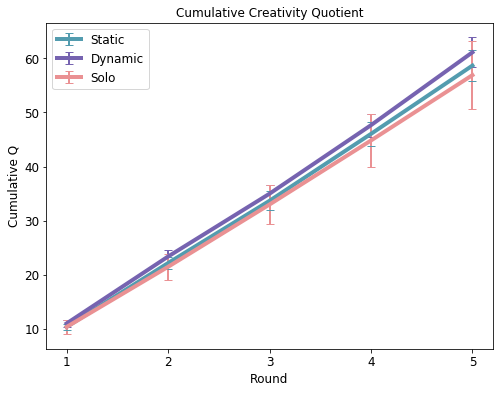

In [62]:
compute_lumped_temporal_cr_vs_st_vs_dy_cq(comp)

### Trialwise

In [63]:
def compute_temporal_st_vs_dy_uniq(comp):
    plt.rc('figure', figsize = (18,13))
    for trial_id in range(1,7):
        means_s=[]
        conf_s=[]
        means_d=[]
        conf_d=[]
        for round_ in range(1,6):
            #cumulative
            static_list = [np.sum([comp.unique_dict[id_][round__][1]+comp.unique_dict[id_][round__][2] for round__ in range(1,round_+1)]) for id_ in comp.groups['ego_stat'][trial_id]]
            dynamic_list = [np.sum([comp.unique_dict[id_][round__][1]+comp.unique_dict[id_][round__][2] for round__ in range(1,round_+1)]) for id_ in comp.groups['ego_dy'][trial_id]]
            
            means_s.append(mean_confidence_interval(static_list)[0])
            conf_s.append([mean_confidence_interval(static_list)[1],mean_confidence_interval(static_list)[2]])
            
            means_d.append(mean_confidence_interval(dynamic_list)[0])
            conf_d.append([mean_confidence_interval(dynamic_list)[1],mean_confidence_interval(dynamic_list)[2]])
            
            if round_==5:
                aa=np.array(static_list)
                bb=np.array(dynamic_list)
                t, p = stats.ttest_ind(aa,bb)
                print("Trial "+str(trial_id)+":")
                full_t_test(aa,bb)
                print(" ")
        
        means_s=np.array(means_s)
        means_d=np.array(means_d)

        conf_s=np.array(conf_s)
        conf_d=np.array(conf_d)

        yerr_s = np.c_[means_s-conf_s[:,0],conf_s[:,1]-means_s ].T
        yerr_d = np.c_[means_d-conf_d[:,0],conf_d[:,1]-means_d ].T
        
        plt.subplot(2,3,trial_id);

        plt.errorbar(range(len(means_s)), means_s, yerr=yerr_s, color = '#48c8ff',fmt='-',capsize=4,elinewidth=2,lw=4,label = 'Static')
        plt.errorbar(range(len(means_d)), means_d, yerr=yerr_d, color = '#6655ac',fmt='-',capsize=4,elinewidth=2,lw=4,label = 'Dynamic')
        
        plt.title('Trial: '+str(trial_id)+', p-val: '+str(round(p,4)),fontsize=15)
        plt.xlabel("Round",fontsize=15)
        plt.ylabel("Cumulative non-redundant idea count",fontsize=15)
        plt.legend(loc = 'upper left') 
        plt.xticks([0,1,2,3,4],[1,2,3,4,5])
        plt.legend(loc = 'upper left') 
        plt.savefig('plots/SI_st_dy_uniq.eps', format='eps') 

Trial 1:
$m_1=10.89$, $m_2=12.28$, $t(34)=-0.968$, $p=0.3396680684785852$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=0.3396680684785852
$95\%$ C.I. for $m_1-m_2=[-4.221, 1.444]$
 
Trial 2:
$m_1=17.78$, $m_2=17.33$, $t(34)=0.261$, $p=0.7954191871017366$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=0.7954191871017366
$95\%$ C.I. for $m_1-m_2=[-2.914, 3.803]$
 
Trial 3:
$m_1=19.5$, $m_2=15.94$, $t(34)=2.036$, $p=0.04962804049929354$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=0.04962804049929354
$95\%$ C.I. for $m_1-m_2=[0.106, 7.005]$
 
Trial 4:
$m_1=20.67$, $m_2=21.28$, $t(34)=-0.272$, $p=0.7873329323110311$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=0.7873329323110311
$95\%$ C.I. for $m_1-m_2=[-5.050, 3.828]$
 
Trial 5:
$m_1=21.11$, $m_2=18.28$, $t(34)=1.415$, $p=0.166247199648339$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=0.166247199648339
$95\%$ C.I. for $m_1-m_2=[-1.122, 6.789]$
 
Trial 6:
$m_1=19.67$, $m_2=19.67$, 

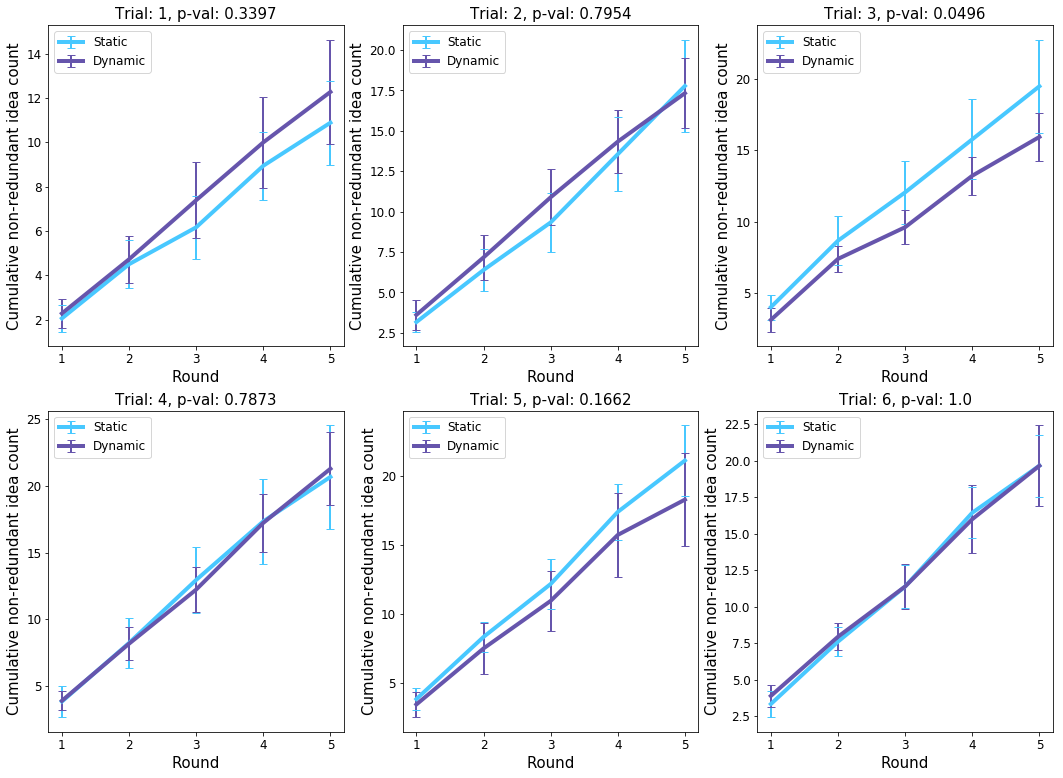

In [64]:
compute_temporal_st_vs_dy_uniq(comp)

In [65]:
def compute_st_vs_dy_ratings(comp):
    plt.rc('figure', figsize = (18,13))
    for trial_id in range(1,7):
        means=[]
        conf=[]
        static_list = [np.mean([r for round_ in range(1,6) for r in comp.ratings_dict[id_][round_][1]+comp.ratings_dict[id_][round_][2]]) for id_ in comp.groups['ego_stat'][trial_id]]
        dynamic_list = [np.mean([r for round_ in range(1,6) for r in comp.ratings_dict[id_][round_][1]+comp.ratings_dict[id_][round_][2]]) for id_ in comp.groups['ego_dy'][trial_id]]
        a=np.array(dynamic_list)
        b=np.array(static_list)
        t, p = stats.ttest_ind(a,b)
        print("Trial "+str(trial_id)+":")
        full_t_test(a,b)
        print(" ")
        
        means.append(mean_confidence_interval(static_list)[0])
        conf.append([mean_confidence_interval(static_list)[1],mean_confidence_interval(static_list)[2]])

        means.append(mean_confidence_interval(dynamic_list)[0])
        conf.append([mean_confidence_interval(dynamic_list)[1],mean_confidence_interval(dynamic_list)[2]])

        means=np.array(means)
        conf=np.array(conf)
        yerr = np.c_[means-conf[:,0],conf[:,1]-means ].T

        x= [b,a]
        plt.subplot(2,3,trial_id);
        plt.bar(range(len(means)), means, yerr=yerr,color=['#48c8ff','#6655ac'],alpha=0.7,error_kw=dict(ecolor='#6A6A6A',alpha=1, lw=3))
        my_xticks = ['Static','Dynamic']
        plt.xticks([0,1], my_xticks,fontsize=15)
        plt.ylim([1.5,3.5])
        plt.title('Trial: '+str(trial_id)+', p-val: '+str(round(p,4)),fontsize=15)
        plt.ylabel('Average rating',fontsize=15)
    plt.savefig('plots/SI_st_dy_avgratings.eps', format='eps')  
         

Trial 1:
$m_1=2.93$, $m_2=2.98$, $t(34)=-1.091$, $p=0.2830704750354328$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=0.2830704750354328
$95\%$ C.I. for $m_1-m_2=[-0.137, 0.040]$
 
Trial 2:
$m_1=3.05$, $m_2=3.01$, $t(34)=0.641$, $p=0.5260145954861029$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=0.5260145954861029
$95\%$ C.I. for $m_1-m_2=[-0.069, 0.136]$
 
Trial 3:
$m_1=2.88$, $m_2=2.9$, $t(34)=-0.358$, $p=0.7227455666517938$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=0.7227455666517938
$95\%$ C.I. for $m_1-m_2=[-0.097, 0.067]$
 
Trial 4:
$m_1=3.18$, $m_2=3.04$, $t(34)=3.107$, $p=0.003805263355680076$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=0.003805263355680076
$95\%$ C.I. for $m_1-m_2=[0.054, 0.241]$
 
Trial 5:
$m_1=3.1$, $m_2=3.07$, $t(34)=0.495$, $p=0.6239082253896903$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=0.6239082253896903
$95\%$ C.I. for $m_1-m_2=[-0.084, 0.140]$
 
Trial 6:
$m_1=3.38$, $m_2=3.19$, $t(34)=3.

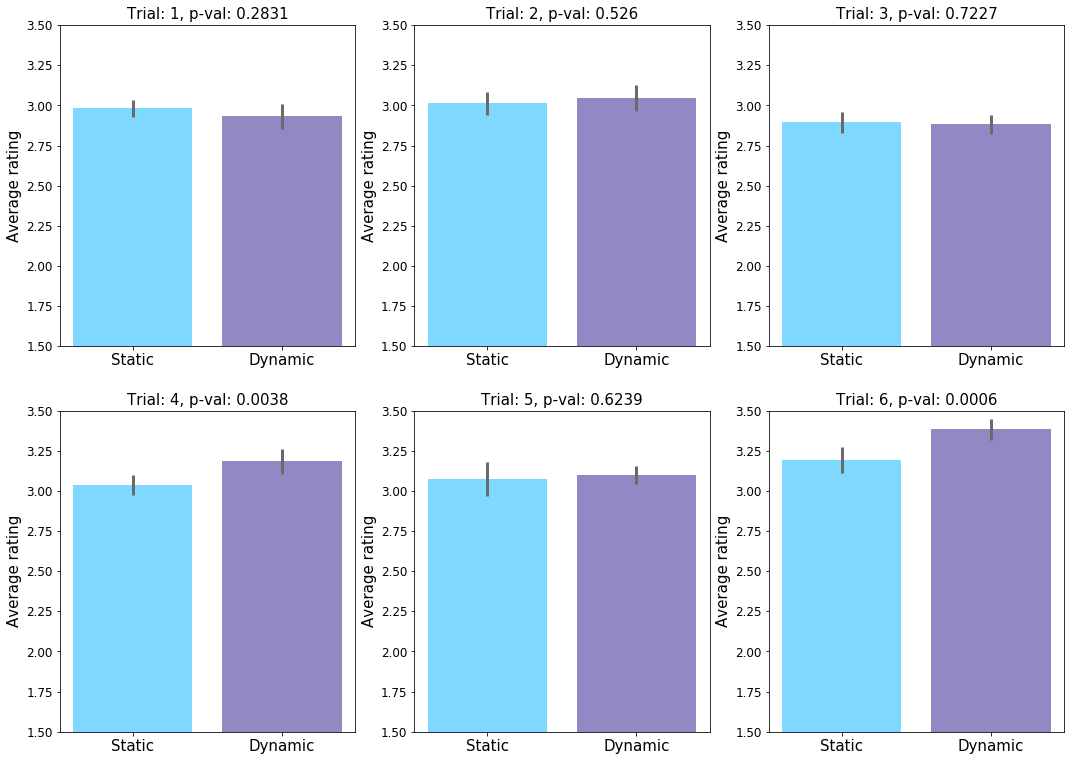

In [66]:
compute_st_vs_dy_ratings(comp)

In [67]:
def compute_temporal_st_vs_dy_cq(comp):
    plt.rc('figure', figsize = (18,13))
    for trial_id in range(1,7):
        means_s=[]
        conf_s=[]
        means_d=[]
        conf_d=[]
        for round_ in range(1,6):
            static_list = [np.sum([comp.cq_dict[id_][round__]['both'] for round__ in range(1,round_+1)]) for id_ in comp.groups['ego_stat'][trial_id]]
            dynamic_list = [np.sum([comp.cq_dict[id_][round__]['both'] for round__ in range(1,round_+1)]) for id_ in comp.groups['ego_dy'][trial_id]]

            means_s.append(mean_confidence_interval(static_list)[0])
            conf_s.append([mean_confidence_interval(static_list)[1],mean_confidence_interval(static_list)[2]])

            means_d.append(mean_confidence_interval(dynamic_list)[0])
            conf_d.append([mean_confidence_interval(dynamic_list)[1],mean_confidence_interval(dynamic_list)[2]])

            if round_==5:
                aa=np.array(static_list)
                bb=np.array(dynamic_list)
                t, p = stats.ttest_ind(aa,bb)
                print("Trial "+str(trial_id)+":")
                full_t_test(aa,bb)
                print(" ")
            
        means_s=np.array(means_s)
        means_d=np.array(means_d)
        conf_s=np.array(conf_s)
        conf_d=np.array(conf_d)

        yerr_s = np.c_[means_s-conf_s[:,0],conf_s[:,1]-means_s ].T
        yerr_d = np.c_[means_d-conf_d[:,0],conf_d[:,1]-means_d ].T

        plt.subplot(2,3,trial_id);
        plt.errorbar(range(len(means_s)), means_s, yerr=yerr_s, color = '#48c8ff',fmt='-',capsize=4,elinewidth=2,lw=4,label = 'Static')
        plt.errorbar(range(len(means_d)), means_d, yerr=yerr_d, color = '#6655ac',fmt='-',capsize=4,elinewidth=2,lw=4,label = 'Dynamic')
        
        plt.title('Trial: '+str(trial_id)+', p-val: '+str(round(p,4)),fontsize=15)
        plt.xlabel("Round",fontsize=15)
        plt.ylabel("Cumulative Q",fontsize=15)
        plt.legend(loc = 'upper left')
        plt.xticks([0,1,2,3,4],[1,2,3,4,5])
    plt.savefig('plots/SI_st_dy_cq_v2.eps', format='eps')   

Trial 1:
$m_1=55.71$, $m_2=51.47$, $t(34)=0.848$, $p=0.4021448231930269$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=0.4021448231930269
$95\%$ C.I. for $m_1-m_2=[-5.628, 14.104]$
 
Trial 2:
$m_1=56.28$, $m_2=60.03$, $t(34)=-0.9$, $p=0.37469616193132294$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=0.37469616193132294
$95\%$ C.I. for $m_1-m_2=[-11.976, 4.481]$
 
Trial 3:
$m_1=61.52$, $m_2=64.08$, $t(34)=-0.548$, $p=0.5875008865522227$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=0.5875008865522227
$95\%$ C.I. for $m_1-m_2=[-11.833, 6.695]$
 
Trial 4:
$m_1=64.17$, $m_2=67.8$, $t(34)=-0.69$, $p=0.4945730117518399$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=0.4945730117518399
$95\%$ C.I. for $m_1-m_2=[-14.010, 6.752]$
 
Trial 5:
$m_1=58.65$, $m_2=64.76$, $t(34)=-1.232$, $p=0.22655233494169777$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=0.22655233494169777
$95\%$ C.I. for $m_1-m_2=[-15.912, 3.689]$
 
Trial 6:
$m_1=55.64$, $m_2

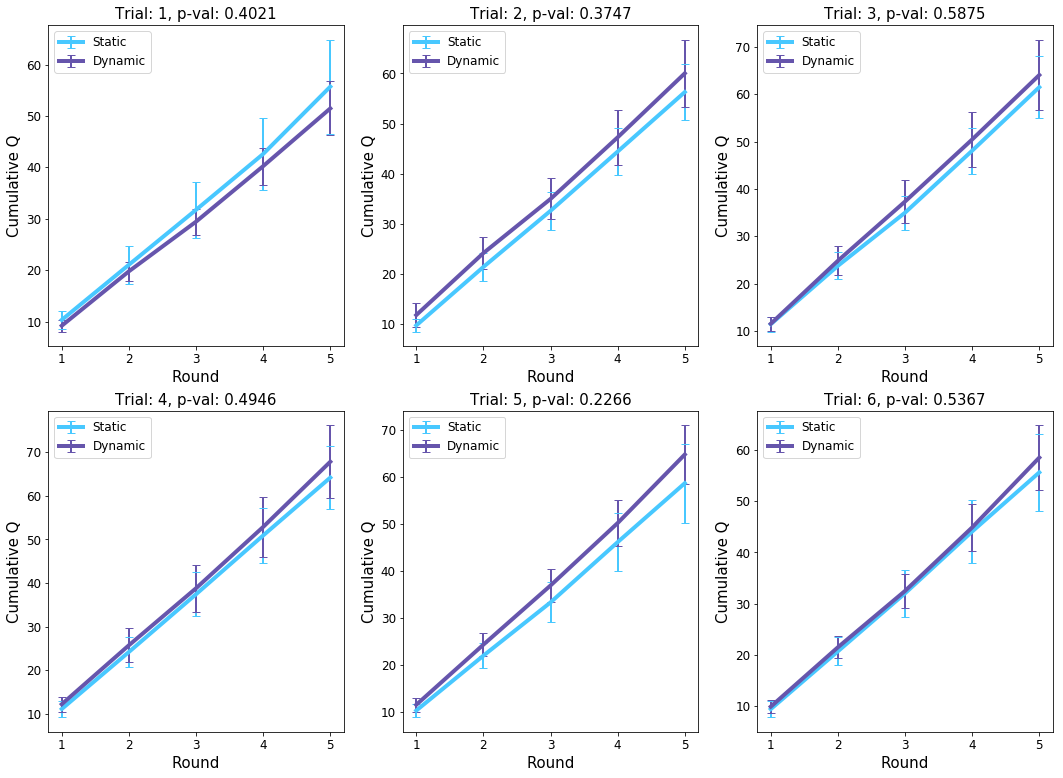

In [68]:
compute_temporal_st_vs_dy_cq(comp)

### Collective-level performance comparisons among conditions


In [69]:
def compute_gr_uniq(comp):
    plt.rc('figure', figsize = (8,6))
    means=[]
    conf=[]
    static_list = [comp.group_unique_dict['static'][trial]['total'] for trial in comp.groups['ego_stat']]
    dynamic_list = [comp.group_unique_dict['dynamic'][trial]['total'] for trial in comp.groups['ego_dy']]
    crowd_list = [comp.group_unique_dict['crowd'][trial]['total'] for trial in comp.groups['crowd']]
    
    a=np.array(crowd_list)
    b=np.array(dynamic_list)
    c=np.array(static_list)
    t, p = stats.ttest_ind(a,b)
    print("dynamic - solo")
    full_t_test(b,a)
    print(" ")
    t, p = stats.ttest_ind(b,c)
    print("dynamic - static")
    full_t_test(b,c)
    print(" ")
    t, p = stats.ttest_ind(c,a)
    print("static - solo")
    full_t_test(c,a)
    print(" ")
    
    means.append(mean_confidence_interval(static_list)[0])
    conf.append([mean_confidence_interval(static_list)[1],mean_confidence_interval(static_list)[2]])

    means.append(mean_confidence_interval(dynamic_list)[0])
    conf.append([mean_confidence_interval(dynamic_list)[1],mean_confidence_interval(dynamic_list)[2]])
    
    means.append(mean_confidence_interval(crowd_list)[0])
    conf.append([mean_confidence_interval(crowd_list)[1],mean_confidence_interval(crowd_list)[2]])
    
    means=np.array(means)
    conf=np.array(conf)
    yerr = np.c_[means-conf[:,0],conf[:,1]-means ].T
    
    plt.bar(range(len(means)), means, yerr=yerr,color=['#48c8ff','#6655ac','#ff7b8e'],alpha=0.7,error_kw=dict(ecolor='#6A6A6A',alpha=1, lw=3))
    my_xticks = ['Static','Dynamic','Solo']
    plt.xticks([0,1,2], my_xticks,fontsize=15)
    plt.ylabel('Non-redundant idea count',fontsize=15)
    plt.savefig('plots/SI_gr_uniq.eps', format='eps') 

dynamic - solo
$m_1=68.33$, $m_2=39.5$, $t(6)=1.928$, $p=0.1021915761369153$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=0.1021915761369153
$95\%$ C.I. for $m_1-m_2=[-4.538, 62.205]$
 
dynamic - static
$m_1=68.33$, $m_2=74.33$, $t(10)=-0.391$, $p=0.7042030755230807$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=0.7042030755230807
$95\%$ C.I. for $m_1-m_2=[-37.235, 25.235]$
 
static - solo
$m_1=74.33$, $m_2=39.5$, $t(6)=1.465$, $p=0.19318118287198857$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=0.19318118287198857
$95\%$ C.I. for $m_1-m_2=[-18.240, 87.906]$
 


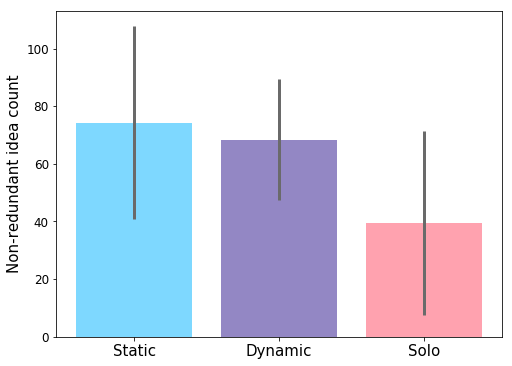

In [70]:
compute_gr_uniq(comp)

In [71]:
def compute_gr_rating(comp):
    plt.rc('figure', figsize = (8,6))
    means=[]
    conf=[]
    
    static_rating_dict = {id_:np.mean([r for round_ in range(1,6) for r in comp.ratings_dict[id_][round_][1]+comp.ratings_dict[id_][round_][2]]) for trial_id in comp.groups['ego_stat'] for id_ in comp.groups['ego_stat'][trial_id]}
    dynamic_rating_dict = {id_:np.mean([r for round_ in range(1,6) for r in comp.ratings_dict[id_][round_][1]+comp.ratings_dict[id_][round_][2]]) for trial_id in comp.groups['ego_dy'] for id_ in comp.groups['ego_dy'][trial_id]}
    crowd_rating_dict = {id_:np.mean([r for round_ in range(1,6) for r in comp.ratings_dict[id_][round_][1]+comp.ratings_dict[id_][round_][2]]) for trial_id in comp.groups['crowd'] for id_ in comp.groups['crowd'][trial_id]}

    static_list = [np.mean([static_rating_dict[id_] for id_ in comp.groups['ego_stat'][trial_id]]) for trial_id in comp.groups['ego_stat']]
    dynamic_list = [np.mean([dynamic_rating_dict[id_] for id_ in comp.groups['ego_dy'][trial_id]]) for trial_id in comp.groups['ego_dy']]
    crowd_list = [np.mean([crowd_rating_dict[id_] for id_ in comp.groups['crowd'][trial_id]]) for trial_id in comp.groups['crowd']]

    a=np.array(crowd_list)
    b=np.array(dynamic_list)
    c=np.array(static_list)

    print("Dynamic vs solo:")
    full_t_test(b,a)
    print(" ")
    t, p = stats.ttest_ind(b,c)
    print("dynamic vs static:")
    full_t_test(b,c)
    print(" ")
    t, p = stats.ttest_ind(c,a)
    print("Static vs solo:")
    full_t_test(c,a)
    print(" ")
        
    means.append(mean_confidence_interval(static_list)[0])
    conf.append([mean_confidence_interval(static_list)[1],mean_confidence_interval(static_list)[2]])

    means.append(mean_confidence_interval(dynamic_list)[0])
    conf.append([mean_confidence_interval(dynamic_list)[1],mean_confidence_interval(dynamic_list)[2]])
    
    means.append(mean_confidence_interval(crowd_list)[0])
    conf.append([mean_confidence_interval(crowd_list)[1],mean_confidence_interval(crowd_list)[2]])
    
    means=np.array(means)
    conf=np.array(conf)
    yerr = np.c_[means-conf[:,0],conf[:,1]-means ].T
    
    plt.bar(range(len(means)), means, yerr=yerr,color=['#48c8ff','#6655ac','#ff7b8e'],alpha=0.7,error_kw=dict(ecolor='#6A6A6A',alpha=1, lw=3))
    my_xticks = ['Static','Dynamic','Solo']
    plt.xticks([0,1,2], my_xticks,fontsize=15)
    plt.ylabel('Average novelty rating',fontsize=15)
    plt.ylim([2,4])
    plt.savefig('plots/SI_gr_rating.eps', format='eps') 

Dynamic vs solo:
$m_1=3.09$, $m_2=3.06$, $t(6)=0.206$, $p=0.8433810722148014$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=0.8433810722148014
$95\%$ C.I. for $m_1-m_2=[-0.276, 0.332]$
 
dynamic vs static:
$m_1=3.09$, $m_2=3.03$, $t(10)=0.665$, $p=0.5212206669230781$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=0.5212206669230781
$95\%$ C.I. for $m_1-m_2=[-0.116, 0.228]$
 
Static vs solo:
$m_1=3.03$, $m_2=3.06$, $t(6)=-0.372$, $p=0.7227866301444901$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=0.7227866301444901
$95\%$ C.I. for $m_1-m_2=[-0.195, 0.139]$
 


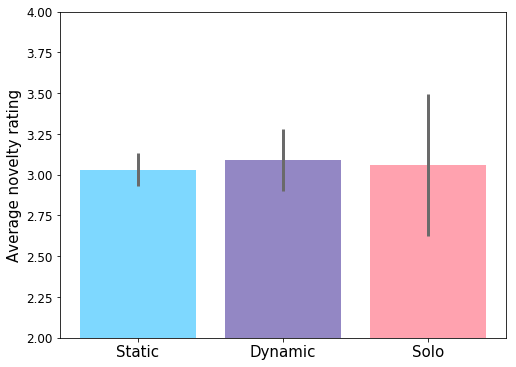

In [72]:
compute_gr_rating(comp)

In [73]:
def compute_gr_cq(comp):
    plt.rc('figure', figsize = (8,6))
    means=[]
    conf=[]
    
    dy_codes = [10,20,30,40,50,60]
    st_codes = [11,21,31,41,51,61]
    cr_codes = [0,1]

    static_list = [comp.group_cq_dict[k]['all'] for k in st_codes]
    dynamic_list = [comp.group_cq_dict[k]['all'] for k in dy_codes]
    crowd_list = [comp.group_cq_dict[k]['all'] for k in cr_codes]
    
    a=np.array(crowd_list)
    b=np.array(dynamic_list)
    c=np.array(static_list)

    print("Dynamic vs solo:")
    full_t_test(b,a)
    print(" ")
    t, p = stats.ttest_ind(b,c)
    print("dynamic vs static:")
    full_t_test(b,c)
    print(" ")
    t, p = stats.ttest_ind(c,a)
    print("Static vs solo:")
    full_t_test(c,a)
    print(" ")
            
    means.append(mean_confidence_interval(static_list)[0])
    conf.append([mean_confidence_interval(static_list)[1],mean_confidence_interval(static_list)[2]])

    means.append(mean_confidence_interval(dynamic_list)[0])
    conf.append([mean_confidence_interval(dynamic_list)[1],mean_confidence_interval(dynamic_list)[2]])
    
    means.append(mean_confidence_interval(crowd_list)[0])
    conf.append([mean_confidence_interval(crowd_list)[1],mean_confidence_interval(crowd_list)[2]])
    
    means=np.array(means)
    conf=np.array(conf)
    yerr = np.c_[means-conf[:,0],conf[:,1]-means ].T
    
    plt.bar(range(len(means)), means, yerr=yerr,color=['#48c8ff','#6655ac','#ff7b8e'],alpha=0.7,error_kw=dict(ecolor='#6A6A6A',alpha=1, lw=3))
    my_xticks = ['Static','Dynamic','Solo']
    plt.xticks([0,1,2], my_xticks,fontsize=15)
    plt.ylabel('Groupwise Q',fontsize=15)
    plt.savefig('plots/SI_gr_cq.eps', format='eps') 


Dynamic vs solo:
$m_1=431.84$, $m_2=401.22$, $t(6)=1.205$, $p=0.2735626206168923$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=0.2735626206168923
$95\%$ C.I. for $m_1-m_2=[-26.107, 87.348]$
 
dynamic vs static:
$m_1=431.84$, $m_2=424.97$, $t(10)=0.365$, $p=0.7230282367039605$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=0.7230282367039605
$95\%$ C.I. for $m_1-m_2=[-31.490, 45.243]$
 
Static vs solo:
$m_1=424.97$, $m_2=401.22$, $t(6)=1.018$, $p=0.3479319378356217$,
Bonferroni-corrected (uncorrected $p$-val $\times 1$) p=0.3479319378356217
$95\%$ C.I. for $m_1-m_2=[-28.317, 75.805]$
 


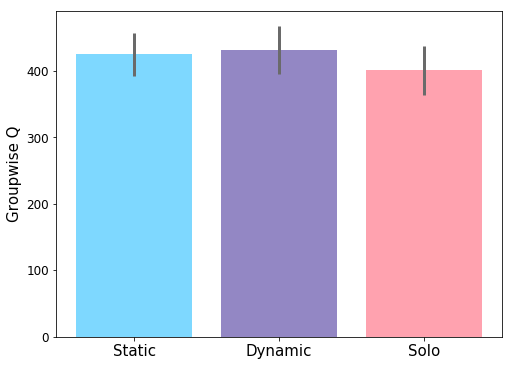

In [74]:
compute_gr_cq(comp)